In [1]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import pandas as pd
import numpy as np
import sklearn
import re
import math
import joblib
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import re
import copy
from tqdm import tqdm
import gc

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report
)

from transformers import (
    AutoTokenizer,
    AutoModel,
    get_linear_schedule_with_warmup
)

import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

from transformers import BertTokenizer, BertForMaskedLM

from sklearn.metrics import (
    recall_score,
    precision_score
  )

from sklearn.metrics import multilabel_confusion_matrix

In [3]:
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import nltk

In [4]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

In [5]:
time_now = pd.Timestamp.now().strftime("%m-%d-%H-%M")
print(f"Time now: {time_now}")

Time now: 06-02-23-03


# Config

In [6]:
class Config:
    def __init__(self):
        super(Config, self).__init__()

        self.SEED = 42
        self.MODEL_PATH = 'bert-base-uncased'
        self.NUM_LABELS_TA = 14
        self.NUM_LABELS_TE = 185

        self.TOKENIZER = BertTokenizer.from_pretrained(self.MODEL_PATH)
        self.MAX_LENGTH = 320
        self.BATCH_SIZE = 16

        self.DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.FULL_FINETUNING = True
        self.LR = 3e-5
        self.OPTIMIZER = 'AdamW'
        self.CRITERION = 'BCEWithLogitsLoss'
        self.N_VALIDATE_DUR_TRAIN = 3
        self.N_WARMUP = 0
        self.SAVE_BEST_ONLY = True
        self.EPOCHS = 50

In [7]:
TACTIC = ['TA0001', 'TA0002', 'TA0003', 'TA0004', 'TA0005', 'TA0006', 'TA0007', 'TA0008', 'TA0009', 'TA0010', 'TA0011', 'TA0040', 'TA0042', 'TA0043']
TECHNIQUE = ['T1001', 'T1003', 'T1005', 'T1006', 'T1007', 'T1008', 'T1010', 'T1011', 'T1012', 'T1014', 'T1016', 'T1018', 'T1020', 'T1021', 'T1025', 'T1027', 'T1029', 'T1030', 'T1033', 'T1036', 'T1037', 'T1039', 'T1040', 'T1041', 'T1046', 'T1047', 'T1048', 'T1049', 'T1052', 'T1053', 'T1055', 'T1056', 'T1057', 'T1059', 'T1068', 'T1069', 'T1071', 'T1072', 'T1074', 'T1078', 'T1080', 'T1082', 'T1083', 'T1087', 'T1090', 'T1091', 'T1092', 'T1095', 'T1098', 'T1102', 'T1104', 'T1105', 'T1106', 'T1110', 'T1111', 'T1112', 'T1113', 'T1114', 'T1115', 'T1119', 'T1120', 'T1123', 'T1124', 'T1125', 'T1127', 'T1129', 'T1132', 'T1133', 'T1134', 'T1135', 'T1136', 'T1137', 'T1140', 'T1176', 'T1185', 'T1187', 'T1189', 'T1190', 'T1195', 'T1197', 'T1199', 'T1200', 'T1201', 'T1202', 'T1203', 'T1204', 'T1205', 'T1207', 'T1210', 'T1211', 'T1212', 'T1213', 'T1216', 'T1218', 'T1220', 'T1221', 'T1222', 'T1480', 'T1482', 'T1485', 'T1486', 'T1489', 'T1490', 'T1491', 'T1495', 'T1496', 'T1497', 'T1498', 'T1499', 'T1505', 'T1518', 'T1525', 'T1526', 'T1528', 'T1529', 'T1531', 'T1534', 'T1535', 'T1537', 'T1538', 'T1539', 'T1542', 'T1543', 'T1546', 'T1547', 'T1548', 'T1550', 'T1552', 'T1553', 'T1555', 'T1556', 'T1557', 'T1558', 'T1559', 'T1560', 'T1561', 'T1562', 'T1563', 'T1564', 'T1565', 'T1566', 'T1567', 'T1568', 'T1569', 'T1570', 'T1571', 'T1572', 'T1573', 'T1574', 'T1578', 'T1580', 'T1583', 'T1584', 'T1585', 'T1586', 'T1587', 'T1588', 'T1589', 'T1590', 'T1591', 'T1592', 'T1593', 'T1594', 'T1595', 'T1596', 'T1597', 'T1598', 'T1599', 'T1600', 'T1601', 'T1602', 'T1606', 'T1608', 'T1609', 'T1610', 'T1611', 'T1612', 'T1613', 'T1614', 'T1615', 'T1619', 'T1620', 'T1621', 'T1622', 'T1647']
TACTICS_TECHNIQUES_RELATIONSHIP_DF = {
"TA0001":pd.Series(['T1078', 'T1091', 'T1133', 'T1189', 'T1190', 'T1195', 'T1199', 'T1200', 'T1566', 'T1659', 'T1669']),
"TA0002":pd.Series(['T1047', 'T1053', 'T1059', 'T1072', 'T1106', 'T1129', 'T1203', 'T1204', 'T1559', 'T1569', 'T1609', 'T1610', 'T1648', 'T1651', 'T1674', 'T1675']),
"TA0003":pd.Series(['T1037', 'T1053', 'T1078', 'T1098', 'T1112', 'T1133', 'T1136', 'T1137', 'T1176', 'T1197', 'T1205', 'T1505', 'T1525', 'T1542', 'T1543', 'T1546', 'T1547', 'T1554', 'T1556', 'T1574', 'T1653', 'T1668', 'T1671']),
"TA0004":pd.Series(['T1037', 'T1053', 'T1055', 'T1068', 'T1078', 'T1098', 'T1134', 'T1484', 'T1543', 'T1546', 'T1547', 'T1548', 'T1574', 'T1611']),
"TA0005":pd.Series(['T1006', 'T1014', 'T1027', 'T1036', 'T1055', 'T1070', 'T1078', 'T1112', 'T1127', 'T1134', 'T1140', 'T1197', 'T1202', 'T1205', 'T1207', 'T1211', 'T1216', 'T1218', 'T1220', 'T1221', 'T1222', 'T1480', 'T1484', 'T1497', 'T1535', 'T1542', 'T1548', 'T1550', 'T1553', 'T1556', 'T1562', 'T1564', 'T1574', 'T1578', 'T1599', 'T1600', 'T1601', 'T1610', 'T1612', 'T1620', 'T1622', 'T1647', 'T1656', 'T1666', 'T1672']),
"TA0006":pd.Series(['T1003', 'T1040', 'T1056', 'T1110', 'T1111', 'T1187', 'T1212', 'T1528', 'T1539', 'T1552', 'T1555', 'T1556', 'T1557', 'T1558', 'T1606', 'T1621', 'T1649']),
"TA0007":pd.Series(['T1007', 'T1010', 'T1012', 'T1016', 'T1018', 'T1033', 'T1040', 'T1046', 'T1049', 'T1057', 'T1069', 'T1082', 'T1083', 'T1087', 'T1120', 'T1124', 'T1135', 'T1201', 'T1217', 'T1482', 'T1497', 'T1518', 'T1526', 'T1538', 'T1580', 'T1613', 'T1614', 'T1615', 'T1619', 'T1622', 'T1652', 'T1654', 'T1673']),
"TA0008":pd.Series(['T1021', 'T1072', 'T1080', 'T1091', 'T1210', 'T1534', 'T1550', 'T1563', 'T1570']),
"TA0009":pd.Series(['T1005', 'T1025', 'T1039', 'T1056', 'T1074', 'T1113', 'T1114', 'T1115', 'T1119', 'T1123', 'T1125', 'T1185', 'T1213', 'T1530', 'T1557', 'T1560', 'T1602']),
"TA0010":pd.Series(['T1011', 'T1020', 'T1029', 'T1030', 'T1041', 'T1048', 'T1052', 'T1537', 'T1567']),
"TA0011":pd.Series(['T1001', 'T1008', 'T1071', 'T1090', 'T1092', 'T1095', 'T1102', 'T1104', 'T1105', 'T1132', 'T1205', 'T1219', 'T1568', 'T1571', 'T1572', 'T1573', 'T1659', 'T1665']),
"TA0040":pd.Series(['T1485', 'T1486', 'T1489', 'T1490', 'T1491', 'T1495', 'T1496', 'T1498', 'T1499', 'T1529', 'T1531', 'T1561', 'T1565', 'T1657', 'T1667']),                
"TA0042":pd.Series(['T1583', 'T1584', 'T1585', 'T1586', 'T1587', 'T1588', 'T1608', 'T1650']),
"TA0043":pd.Series(['T1589', 'T1590', 'T1591', 'T1592', 'T1593', 'T1594', 'T1595', 'T1596', 'T1597', 'T1598'])
}

In [8]:
df = pd.read_csv('merged_all_columns.csv', encoding='utf-8')
# df_attack['tactic_label'] = df_attack.apply(lambda x: list(x[TACTIC]), axis=1)
# df_attack['technique_label'] = df_attack.apply(lambda x: list(x[TECHNIQUE]), axis=1)

df_tactic_labels = df[TACTIC]
df_technique_labels = df[TECHNIQUE]

In [9]:
print(df_tactic_labels)

      TA0001  TA0002  TA0003  TA0004  TA0005  TA0006  TA0007  TA0008  TA0009  \
0          1       1       0       0       0       0       0       0       0   
1          1       1       0       0       0       0       0       0       0   
2          0       1       0       0       0       1       0       0       0   
3          1       1       0       0       0       0       0       0       0   
4          1       0       0       1       1       0       0       0       0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
1513       0       1       1       0       0       0       0       0       0   
1514       0       0       0       0       0       0       0       0       0   
1515       0       0       0       1       0       0       0       0       0   
1516       0       1       0       0       0       0       0       0       1   
1517       0       0       0       0       0       0       0       0       0   

      TA0010  TA0011  TA0040  TA0042  T

In [10]:
print(df_technique_labels)

      T1001  T1003  T1005  T1006  T1007  T1008  T1010  T1011  T1012  T1014  \
0         0      0      0      0      0      0      0      0      0      0   
1         0      0      0      0      0      0      0      0      0      0   
2         0      1      0      0      0      0      0      0      0      0   
3         0      0      0      0      0      0      0      0      0      0   
4         0      0      0      0      0      0      0      0      0      0   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
1513      0      0      0      0      0      0      0      0      0      0   
1514      0      0      0      0      0      0      0      0      0      0   
1515      0      0      0      0      0      0      0      0      0      0   
1516      0      0      1      0      0      0      0      0      0      0   
1517      0      0      0      0      0      0      0      0      0      0   

      ...  T1611  T1612  T1613  T1614  T1615  T1619  T1620  T16

In [11]:
df['tactic_label'] = df.apply(lambda x: list(x[TACTIC]), axis=1)
df['technique_label'] = df.apply(lambda x: list(x[TECHNIQUE]), axis=1)


# Data processing

In [12]:
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import nltk

In [13]:
import nltk

resources = [
    "punkt",
    "stopwords",
    "wordnet",
    "omw-1.4",
    "averaged_perceptron_tagger",
    "averaged_perceptron_tagger_eng"
]

for res in resources:
    try:
        nltk.data.find(res)
        print(f"{res} ✅ 已安裝")
    except LookupError:
        print(f"{res} ⛔ 未安裝，開始下載...")
        nltk.download(res)


punkt ⛔ 未安裝，開始下載...
stopwords ⛔ 未安裝，開始下載...
wordnet ⛔ 未安裝，開始下載...
omw-1.4 ⛔ 未安裝，開始下載...
averaged_perceptron_tagger ⛔ 未安裝，開始下載...
averaged_perceptron_tagger_eng ⛔ 未安裝，開始下載...


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_t

In [14]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return 'n'

def ioc_sub(text):
    def reg_handler(obj):
        s = obj.group(1)
        s = ' '.join(s.split('\\'))
        return s

    def file_handler(obj):
        s = obj.group(2)
        s = s.split('\\')[-1]
        return s
    
    text = re.sub(r'(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\.|\[\.\])){3}(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\/([0-2][0-9]|3[0-2]|[0-9]))?', 'IPv4', text)
    text = re.sub(r'\b(\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3})\b', 'IP', text)
    text = re.sub(r'\b(CVE\-[0-9]{4}\-[0-9]{4,6})\b', 'CVE', text)
    text = re.sub(r'CVE-[0-9]{4}-[0-9]{4,6}', 'vulnerability', text)
    text = re.sub(r'\b([a-z][_a-z0-9-.]+@[a-z0-9-]+\.[a-z]+)\b', 'email', text)
    text = re.sub(r'\b((HKLM|HKCU|HKCR|HKU|HKCC)\\[\\A-Za-z0-9-_]+)\b', reg_handler, text)
    text = re.sub(r'\b([a-zA-Z]{1}:\\([0-9a-zA-Z_\.\-\/\\]+))\b', file_handler, text)
    text = re.sub(r'\b([a-f0-9]{32}|[A-F0-9]{32})\b', 'MD5', text)
    text = re.sub(r'\b([a-f0-9]{40}|[A-F0-9]{40})\b', 'SHA1', text)
    text = re.sub(r'\b([a-f0-9]{64}|[A-F0-9]{64})\b', 'SHA256', text)
    text = re.sub(r'\d+:[A-Za-z0-9/+]+:[A-Za-z0-9/+]+', 'ssdeep', text)
    text = re.sub(r'\b[a-fA-F\d]{32}\b|\b[a-fA-F\d]{40}\b|\b[a-fA-F\d]{64}\b', 'hash', text)
    text = re.sub(r'h[tx][tx]ps?:[\\\/][\\\/](?:[0-9a-zA-Z_\.\-\/\\]|\[\.\])+', 'URL', text)
    text = re.sub(r'((?:[0-9a-zA-Z_\-]+\.)+(?:(?!exe|dll)[a-z]{2,4}))', 'domain', text)
    text = re.sub(r'[a-fA-F0-9]{16}', '', text)
    text = re.sub(r'[0-9]{8}', '', text)
    text = re.sub(r'x[A-Fa-f0-9]{2}', '', text)
    
    return text

def rmstopword_and_lemmatize(text):
    token = [word for word in word_tokenize(text.lower()) if word not in stopwords.words('english')]
    # tag = pos_tag(token)
    tag = nltk.pos_tag(token, lang='eng')
    lemmatizer = WordNetLemmatizer()
    text = ' '.join(list(map(lambda x: lemmatizer.lemmatize(x[0], pos=get_wordnet_pos(x[1])), tag)))
    
    return text

def preprocess(text):
    text = str(text)
    #text = text.lower()
    text = re.sub(r'etc\.', '', text)
    text = re.sub(r'et al\.', '', text)
    text = re.sub(r'e\.g\.', '', text)
    text = re.sub(r'i\.e\.', '', text)
    #text = re.sub(r'\[.\]', '.', text)
    text = re.sub(r'\[\d+\]', '', text)
    
    text = ioc_sub(text)
    
    text = re.sub(r'[^A-Za-z0-9_\[\]]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    
    text = rmstopword_and_lemmatize(text)
    
    text = re.sub(r'[\[\]]', ' ', text)
    text = re.sub(r' [a-z0-9] ', '', text)
    
    return text


In [15]:
df['text_clean'] = df['Text'].map(lambda t: preprocess(t))

In [16]:
print(df['text_clean'][0])

waspthemes visual cs style editor aka yellow pencil visual theme customizer plugin2wordpress allows yp_option_update csrf demonstrate use yp_remote_get obtain admin access


In [17]:
print(df.iloc[0])

ID                                                    CVE_2019_11886
Text               The WaspThemes Visual CSS Style Editor (aka ye...
TA0001                                                             1
TA0002                                                             1
TA0003                                                             0
                                         ...                        
T1622                                                              0
T1647                                                              0
tactic_label              [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
technique_label    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
text_clean         waspthemes visual cs style editor aka yellow p...
Name: 0, Length: 204, dtype: object


# Dataset & Dataloader

In [18]:
def get_texts(df):
    texts = df['text']
    texts = texts.values.tolist()
    return texts

def get_labels(df):
    labels = df['labels'].values
    return labels

def get_ids(df):
    ids = df['ID'].values.tolist()

In [19]:
from torch.utils.data import Dataset, DataLoader
class TransformerDataset_ta(Dataset):
    def __init__(self, df, indices, set_type=None):
        super(TransformerDataset_ta, self).__init__()

        df = df.iloc[indices]
        self.texts = get_texts(df)
        self.set_type = set_type
        if self.set_type != 'test':
            self.labels = get_labels(df)

        self.tokenizer = Config().TOKENIZER
        self.max_length = Config().MAX_LENGTH

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        tokenized = self.tokenizer.encode_plus(
            self.texts[index],
            max_length=self.max_length,
            pad_to_max_length=True,
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt'
        )

        input_ids = tokenized['input_ids'].squeeze()
        attention_mask = tokenized['attention_mask'].squeeze()

        if self.set_type != 'test':
            return {
                'input_ids': input_ids.long(),
                'attention_mask': attention_mask.long(),
                'labels': torch.Tensor(self.labels[index]).float(),
            }

        return {
            'input_ids': input_ids.long(),
            'attention_mask': attention_mask.long(),
        }

In [20]:

class TransformerDataset_te(Dataset):
    def __init__(self, df, indices, set_type=None):
        super(TransformerDataset_te, self).__init__()

        df = df.iloc[indices]
        self.texts = get_texts(df)
        self.set_type = set_type
        if self.set_type != 'test':
            self.labels = get_labels(df)

        self.tokenizer = Config().TOKENIZER
        self.max_length = Config().MAX_LENGTH

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        tokenized = self.tokenizer.encode_plus(
            self.texts[index],
            max_length=self.max_length,
            pad_to_max_length=True,
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt'
        )

        input_ids = tokenized['input_ids'].squeeze()
        attention_mask = tokenized['attention_mask'].squeeze()

        if self.set_type != 'test':
            return {
                'input_ids': input_ids.long(),
                'attention_mask': attention_mask.long(),
                'labels': torch.Tensor(self.labels[index]).float(),
            }

        return {
            'input_ids': input_ids.long(),
            'attention_mask': attention_mask.long(),
        }

In [21]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, random_state=2222)
validation, test = train_test_split(test, test_size=0.5, random_state=2222)

In [22]:
df_ta_train = train[['text_clean', 'tactic_label']]
df_ta_val = validation[['text_clean', 'tactic_label']]
df_ta_test = test[['text_clean', 'tactic_label']]
df_ta_train = df_ta_train.rename(columns={'text_clean':'text', 'tactic_label':'labels'})
df_ta_val = df_ta_val.rename(columns={'text_clean':'text', 'tactic_label':'labels'})
df_ta_test = df_ta_test.rename(columns={'text_clean':'text', 'tactic_label':'labels'})


In [23]:
# df_te_train = df.iloc[train.index][['text_clean', 'technique_label']]
# df_te_val = df.iloc[validation.index][['text_clean', 'technique_label']]
# df_te_test = df.iloc[test.index][['text_clean', 'technique_label']]
# df_te_train = df_te_train.rename(columns={'text_clean':'text', 'technique_label':'labels'})
# df_te_val = df_te_val.rename(columns={'text_clean':'text', 'technique_label':'labels'})
# df_te_test = df_te_test.rename(columns={'text_clean':'text', 'technique_label':'labels'})

In [24]:
train_data_ta = TransformerDataset_ta(df_ta_train, range(len(df_ta_train)))
val_data_ta = TransformerDataset_ta(df_ta_val, range(len(df_ta_val)))
test_data_ta = TransformerDataset_ta(df_ta_test, range(len(df_ta_test)))

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

c:\Users\user\anaconda3\envs\dl_final\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\user\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [25]:
# train_data_te = TransformerDataset_te(df_ta_train, range(len(df_te_train)))
# val_data_te = TransformerDataset_te(df_ta_val, range(len(df_te_val)))
# test_data_te = TransformerDataset_te(df_ta_test, range(len(df_te_test)))

In [26]:
train_dataloader_ta = DataLoader(train_data_ta, batch_size=Config().BATCH_SIZE)
val_dataloader_ta = DataLoader(val_data_ta, batch_size=Config().BATCH_SIZE)
test_dataloader_ta = DataLoader(test_data_ta, batch_size=Config().BATCH_SIZE)

In [27]:
# train_dataloader_te = DataLoader(train_data_te, batch_size=Config().BATCH_SIZE)
# val_dataloader_te = DataLoader(val_data_te, batch_size=Config().BATCH_SIZE)
# test_dataloader_te = DataLoader(test_data_te, batch_size=Config().BATCH_SIZE)

In [28]:
train_dataloader = train_dataloader_ta
val_dataloader = val_dataloader_ta
test_dataloader = test_dataloader_ta

In [29]:
b = next(iter(train_dataloader_ta))
for k, v in b.items():
    print(f'{k} shape: {v.shape}')

input_ids shape: torch.Size([16, 320])
attention_mask shape: torch.Size([16, 320])
labels shape: torch.Size([16, 14])


# Model

In [30]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.transformer_model = AutoModel.from_pretrained(
                Config().MODEL_PATH
        )
        self.dropout = nn.Dropout(0.3)

        self.output = nn.Linear(768, Config().NUM_LABELS_TA)

    def forward(
        self,
        input_ids,
        attention_mask=None,
        token_type_ids=None
        ):

        _, o2 = self.transformer_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=False
        )

        x = self.dropout(o2)
        out = self.output(x)

        return out

# Train and test

In [31]:
BEST_F1 = 0
BEST_TRUE = []
BEST_PREDICTED = []

In [32]:
metrics_log = [] 

In [33]:
def val(model, val_dataloader, criterion, is_final_test=False):
    global BEST_F1, BEST_TRUE, BEST_PREDICTED, device

    val_loss = 0
    true, pred = [], []

    model.eval()

    results = {}

    for step, batch in enumerate(val_dataloader):
        b_input_ids = batch['input_ids'].to(device)
        b_attention_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        with torch.no_grad():
            logits = model(input_ids=b_input_ids, attention_mask=b_attention_mask)

            loss = criterion(logits, b_labels)
            val_loss += loss.item()

            logits = torch.sigmoid(logits)
            logits = np.round(logits.cpu().numpy())
            labels = b_labels.cpu().numpy()

            pred.extend(logits)
            true.extend(labels)

    # avg_val_loss = val_loss / len(val_dataloader)
    # print('Val loss:', avg_val_loss)
    # print('Val accuracy:', accuracy_score(true, pred))

    # print('Val precision:', precision_score(true, pred, average='weighted'))
    # print('Val recall:', recall_score(true, pred, average='weighted'))

    # val_micro_f1_score = f1_score(true, pred, average='micro')
    # print('Val micro f1 score:', val_micro_f1_score)

    # val_macro_f1_score = f1_score(true, pred, average='macro')
    # print('Val macro f1 score:', val_macro_f1_score)

    val_weighted_f1_score = f1_score(true, pred, average='weighted')
    # print('Val weighted f1 score:', val_weighted_f1_score)

    results.update({
        "f1_sampled": f1_score(true, pred, average='samples', zero_division=0),
        "f1_micro": f1_score(true, pred, average='micro', zero_division=0),
        "f1_macro": f1_score(true, pred, average='macro', zero_division=0),
        "f_05_sample": fbeta_score(true, pred, average='samples', beta=0.5, zero_division=0),
        "f_05_micro": fbeta_score(true, pred, average='micro', beta=0.5, zero_division=0),
        "f_05_macro": fbeta_score(true, pred, average='macro', beta=0.5, zero_division=0),
        "precision_sampled": precision_score(true, pred, average='samples', zero_division=0),
        "precision_micro": precision_score(true, pred, average='micro', zero_division=0),
        "precision_macro": precision_score(true, pred, average='macro', zero_division=0),
        "recall_sampled": recall_score(true, pred, average='samples', zero_division=0),
        "recall_micro": recall_score(true, pred, average='micro', zero_division=0),
        "recall_macro": recall_score(true, pred, average='macro', zero_division=0),
        "accuracy": accuracy_score(true, pred),
        })

    labels_float = labels.astype(float)
    results.update({
        "coverage_error": coverage_error(labels_float, logits),
        "label_ranking_loss": label_ranking_loss(labels_float, logits),
        "lrap": label_ranking_average_precision_score(labels_float, logits),
    })

    metrics_log.append(results.copy())

    print(results)


    if (is_final_test is True):
      BEST_F1 = val_weighted_f1_score
      BEST_TRUE = true
      BEST_PREDICTED = pred
    elif (val_weighted_f1_score > BEST_F1):
      BEST_F1 = val_weighted_f1_score
      BEST_TRUE = true
      BEST_PREDICTED = pred

    return val_weighted_f1_score



In [34]:
def train(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, epoch):
    global device
    nv = Config().N_VALIDATE_DUR_TRAIN
    temp = len(train_dataloader) // nv
    temp = temp - (temp % 100)
    validate_at_steps = [temp * x for x in range(1, nv + 1)]

    train_loss = 0
    train_losses = []

    for step, batch in enumerate(tqdm(train_dataloader,
                                      desc='Epoch ' + str(epoch))):
        model.train()

        b_input_ids = batch['input_ids'].to(device)
        b_attention_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        optimizer.zero_grad()

        logits = model(input_ids=b_input_ids, attention_mask=b_attention_mask)

        loss = criterion(logits, b_labels)
        train_loss += loss.item()

        loss.backward()

        optimizer.step()

        scheduler.step()

        if step in validate_at_steps:
            print(f'-- Step: {step}')
            _ = val(model, val_dataloader, criterion)


    avg_train_loss = train_loss / len(train_dataloader)
    print('Training loss:', avg_train_loss)

In [35]:
def run():
    global train_data, val_data, test_data, train_dataloader, val_dataloader, test_dataloader, model
    torch.manual_seed(Config().SEED)

    criterion = nn.BCEWithLogitsLoss()

    if Config().FULL_FINETUNING:
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {
                "params": [
                    p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
                ],
                "weight_decay": 0.001,
            },
            {
                "params": [
                    p for n, p in param_optimizer if any(nd in n for nd in no_decay)
                ],
                "weight_decay": 0.0,
            },
        ]
        optimizer = optim.AdamW(optimizer_parameters, lr=Config().LR)

    num_training_steps = len(train_dataloader) * Config().EPOCHS
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps
    )

    max_val_weighted_f1_score = float('-inf')
    for epoch in range(Config().EPOCHS):
        train(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, epoch)
        val_weighted_f1_score = val(model, val_dataloader, criterion)

        if Config().SAVE_BEST_ONLY:
            if val_weighted_f1_score > max_val_weighted_f1_score:
                best_model = copy.deepcopy(model)

                model_name = 'secroberta_best_model'
                torch.save(best_model.state_dict(), model_name + '.pt')

                print(f'--- Best Model. Val: {max_val_weighted_f1_score} -> {val_weighted_f1_score}')
                max_val_weighted_f1_score = val_weighted_f1_score

    return best_model, max_val_weighted_f1_score

# Tactic_multi model

In [36]:
from sklearn.metrics import coverage_error, label_ranking_average_precision_score, label_ranking_loss
from sklearn.metrics import hamming_loss, precision_score, recall_score, f1_score, fbeta_score
from sklearn.metrics import accuracy_score

In [37]:
project_dir = './'
config = Config()
device = Config().DEVICE
model = Model()
model.to(device)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Model(
  (transformer_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [38]:
best_model_ta, best_val_weighted_f1_score_ta = run()

Epoch 0:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 0:   1%|▏         | 1/76 [00:04<05:46,  4.62s/it]

{'f1_sampled': 0.207720532391585, 'f1_micro': 0.22700587084148727, 'f1_macro': 0.12198549115504297, 'f_05_sample': 0.16612840385552088, 'f_05_micro': 0.1728247914183552, 'f_05_macro': 0.10213858952702962, 'precision_sampled': 0.1481516290726817, 'precision_micro': 0.14910025706940874, 'precision_macro': 0.09698613286831799, 'recall_sampled': 0.43410087719298246, 'recall_micro': 0.47540983606557374, 'recall_macro': 0.3146799993582339, 'accuracy': 0.0, 'coverage_error': np.float64(10.625), 'label_ranking_loss': np.float64(0.6470425407925408), 'lrap': np.float64(0.23015873015873012)}


Epoch 0: 100%|██████████| 76/76 [00:27<00:00,  2.80it/s]


Training loss: 0.39446987407772166
{'f1_sampled': 0.0, 'f1_micro': 0.0, 'f1_macro': 0.0, 'f_05_sample': 0.0, 'f_05_micro': 0.0, 'f_05_macro': 0.0, 'precision_sampled': 0.0, 'precision_micro': 0.0, 'precision_macro': 0.0, 'recall_sampled': 0.0, 'recall_micro': 0.0, 'recall_macro': 0.0, 'accuracy': 0.05921052631578947, 'coverage_error': np.float64(14.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.1607142857142857)}
--- Best Model. Val: -inf -> 0.0


Epoch 1:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 1:   1%|▏         | 1/76 [00:02<03:36,  2.88s/it]

{'f1_sampled': 0.0, 'f1_micro': 0.0, 'f1_macro': 0.0, 'f_05_sample': 0.0, 'f_05_micro': 0.0, 'f_05_macro': 0.0, 'precision_sampled': 0.0, 'precision_micro': 0.0, 'precision_macro': 0.0, 'recall_sampled': 0.0, 'recall_micro': 0.0, 'recall_macro': 0.0, 'accuracy': 0.05921052631578947, 'coverage_error': np.float64(14.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.1607142857142857)}


Epoch 1: 100%|██████████| 76/76 [01:20<00:00,  1.06s/it]


Training loss: 0.2967533482924888
{'f1_sampled': 0.0, 'f1_micro': 0.0, 'f1_macro': 0.0, 'f_05_sample': 0.0, 'f_05_micro': 0.0, 'f_05_macro': 0.0, 'precision_sampled': 0.0, 'precision_micro': 0.0, 'precision_macro': 0.0, 'recall_sampled': 0.0, 'recall_micro': 0.0, 'recall_macro': 0.0, 'accuracy': 0.05921052631578947, 'coverage_error': np.float64(14.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.1607142857142857)}


Epoch 2:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 2:   1%|▏         | 1/76 [00:02<03:22,  2.70s/it]

{'f1_sampled': 0.0, 'f1_micro': 0.0, 'f1_macro': 0.0, 'f_05_sample': 0.0, 'f_05_micro': 0.0, 'f_05_macro': 0.0, 'precision_sampled': 0.0, 'precision_micro': 0.0, 'precision_macro': 0.0, 'recall_sampled': 0.0, 'recall_micro': 0.0, 'recall_macro': 0.0, 'accuracy': 0.05921052631578947, 'coverage_error': np.float64(14.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.1607142857142857)}


Epoch 2: 100%|██████████| 76/76 [01:19<00:00,  1.05s/it]


Training loss: 0.2841561575861354
{'f1_sampled': 0.21425438596491225, 'f1_micro': 0.2857142857142857, 'f1_macro': 0.08204876452299133, 'f_05_sample': 0.23578477443609022, 'f_05_micro': 0.4555084745762712, 'f_05_macro': 0.09667513293527018, 'precision_sampled': 0.2598684210526316, 'precision_micro': 0.7543859649122807, 'precision_macro': 0.11238761238761238, 'recall_sampled': 0.19791666666666669, 'recall_micro': 0.1762295081967213, 'recall_macro': 0.06768025606469003, 'accuracy': 0.16447368421052633, 'coverage_error': np.float64(14.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.1607142857142857)}
--- Best Model. Val: 0.0 -> 0.2074324451204627


Epoch 3:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 3:   1%|▏         | 1/76 [00:02<03:07,  2.50s/it]

{'f1_sampled': 0.1989035087719298, 'f1_micro': 0.2702702702702703, 'f1_macro': 0.07912638739706408, 'f_05_sample': 0.21824091478696744, 'f_05_micro': 0.4424778761061947, 'f_05_macro': 0.09808410543704661, 'precision_sampled': 0.24013157894736842, 'precision_micro': 0.7692307692307693, 'precision_macro': 0.12244897959183675, 'recall_sampled': 0.18475877192982457, 'recall_micro': 0.16393442622950818, 'recall_macro': 0.06275269541778976, 'accuracy': 0.15789473684210525, 'coverage_error': np.float64(14.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.1607142857142857)}


Epoch 3: 100%|██████████| 76/76 [01:03<00:00,  1.19it/s]


Training loss: 0.2640937868701784
{'f1_sampled': 0.34849624060150375, 'f1_micro': 0.42777777777777776, 'f1_macro': 0.14185674269707885, 'f_05_sample': 0.372661421181158, 'f_05_micro': 0.5437853107344632, 'f_05_macro': 0.16369355580678654, 'precision_sampled': 0.40460526315789475, 'precision_micro': 0.6637931034482759, 'precision_macro': 0.21348850274573108, 'recall_sampled': 0.3384868421052632, 'recall_micro': 0.3155737704918033, 'recall_macro': 0.1313898457250004, 'accuracy': 0.23026315789473684, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.6919070512820513), 'lrap': np.float64(0.3452380952380953)}
--- Best Model. Val: 0.2074324451204627 -> 0.33661948385911744


Epoch 4:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 4:   1%|▏         | 1/76 [00:02<02:58,  2.37s/it]

{'f1_sampled': 0.3511278195488722, 'f1_micro': 0.43010752688172044, 'f1_macro': 0.14338415207980423, 'f_05_sample': 0.3727527954501639, 'f_05_micro': 0.5291005291005291, 'f_05_macro': 0.16341316351370744, 'precision_sampled': 0.40460526315789475, 'precision_micro': 0.625, 'precision_macro': 0.2054157175916799, 'recall_sampled': 0.35000000000000003, 'recall_micro': 0.32786885245901637, 'recall_macro': 0.13595693609683415, 'accuracy': 0.21710526315789475, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.6919070512820513), 'lrap': np.float64(0.3452380952380953)}


Epoch 4: 100%|██████████| 76/76 [00:57<00:00,  1.31it/s]


Training loss: 0.23800126816097059
{'f1_sampled': 0.31920426065162905, 'f1_micro': 0.3942857142857143, 'f1_macro': 0.1276697648499128, 'f_05_sample': 0.3438674812030075, 'f_05_micro': 0.5164670658682635, 'f_05_macro': 0.1493948069423848, 'precision_sampled': 0.375, 'precision_micro': 0.6509433962264151, 'precision_macro': 0.2107844486022452, 'recall_sampled': 0.3053728070175439, 'recall_micro': 0.2827868852459016, 'recall_macro': 0.11749499840953607, 'accuracy': 0.19736842105263158, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7335737179487178), 'lrap': np.float64(0.31249999999999994)}


Epoch 5:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 5:   1%|▏         | 1/76 [00:02<03:01,  2.43s/it]

{'f1_sampled': 0.3419172932330827, 'f1_micro': 0.41509433962264153, 'f1_macro': 0.13670256835128416, 'f_05_sample': 0.3646204855086434, 'f_05_micro': 0.511968085106383, 'f_05_macro': 0.15565176083434887, 'precision_sampled': 0.39473684210526316, 'precision_micro': 0.6062992125984252, 'precision_macro': 0.19348118122105332, 'recall_sampled': 0.33190789473684207, 'recall_micro': 0.3155737704918033, 'recall_macro': 0.13129855100366644, 'accuracy': 0.20394736842105263, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.6919070512820513), 'lrap': np.float64(0.3452380952380953)}


Epoch 5: 100%|██████████| 76/76 [00:58<00:00,  1.30it/s]


Training loss: 0.2124036466212649
{'f1_sampled': 0.39902882205513784, 'f1_micro': 0.46831955922865015, 'f1_macro': 0.1982109172490787, 'f_05_sample': 0.43020311194653305, 'f_05_micro': 0.5902777777777778, 'f_05_macro': 0.24651837745825608, 'precision_sampled': 0.47039473684210525, 'precision_micro': 0.7142857142857143, 'precision_macro': 0.3125059457745362, 'recall_sampled': 0.37883771929824556, 'recall_micro': 0.3483606557377049, 'recall_macro': 0.15900228793958818, 'accuracy': 0.28289473684210525, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.717948717948718), 'lrap': np.float64(0.3541666666666667)}
--- Best Model. Val: 0.33661948385911744 -> 0.4183418201968676


Epoch 6:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 6:   1%|▏         | 1/76 [00:02<03:03,  2.44s/it]

{'f1_sampled': 0.4154761904761905, 'f1_micro': 0.4838709677419355, 'f1_macro': 0.2033041009447543, 'f_05_sample': 0.4466504803675856, 'f_05_micro': 0.5952380952380952, 'f_05_macro': 0.24853991675268805, 'precision_sampled': 0.4868421052631579, 'precision_micro': 0.703125, 'precision_macro': 0.30989414396855414, 'recall_sampled': 0.3952850877192982, 'recall_micro': 0.36885245901639346, 'recall_macro': 0.16706126384247227, 'accuracy': 0.29605263157894735, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.686698717948718), 'lrap': np.float64(0.3764880952380953)}


Epoch 6: 100%|██████████| 76/76 [01:03<00:00,  1.21it/s]


Training loss: 0.1941729017386311
{'f1_sampled': 0.37493734335839596, 'f1_micro': 0.45194805194805193, 'f1_macro': 0.17153385971051918, 'f_05_sample': 0.403828581871345, 'f_05_micro': 0.5383663366336634, 'f_05_macro': 0.21099498296171487, 'precision_sampled': 0.4407894736842105, 'precision_micro': 0.6170212765957447, 'precision_macro': 0.3409612074672315, 'recall_sampled': 0.3607456140350877, 'recall_micro': 0.35655737704918034, 'recall_macro': 0.15004515715605168, 'accuracy': 0.2236842105263158, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.6898237179487179), 'lrap': np.float64(0.3608630952380953)}


Epoch 7:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 7:   1%|▏         | 1/76 [00:02<03:04,  2.45s/it]

{'f1_sampled': 0.38195488721804505, 'f1_micro': 0.46113989637305697, 'f1_macro': 0.18794839042797656, 'f_05_sample': 0.4101856203007519, 'f_05_micro': 0.5480295566502463, 'f_05_macro': 0.23333394872552277, 'precision_sampled': 0.4473684210526316, 'precision_micro': 0.6267605633802817, 'precision_macro': 0.30677655677655674, 'recall_sampled': 0.37006578947368424, 'recall_micro': 0.36475409836065575, 'recall_macro': 0.15802780807003763, 'accuracy': 0.23026315789473684, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.6898237179487179), 'lrap': np.float64(0.3608630952380953)}


Epoch 7: 100%|██████████| 76/76 [01:03<00:00,  1.20it/s]


Training loss: 0.18201037623772495
{'f1_sampled': 0.4283208020050125, 'f1_micro': 0.4876847290640394, 'f1_macro': 0.20703393777784826, 'f_05_sample': 0.45969007235454606, 'f_05_micro': 0.554932735426009, 'f_05_macro': 0.22635009916373505, 'precision_sampled': 0.5021929824561403, 'precision_micro': 0.6111111111111112, 'precision_macro': 0.26017569818625125, 'recall_sampled': 0.4141447368421053, 'recall_micro': 0.4057377049180328, 'recall_macro': 0.1962274392020393, 'accuracy': 0.26973684210526316, 'coverage_error': np.float64(10.875), 'label_ranking_loss': np.float64(0.5512820512820513), 'lrap': np.float64(0.5029761904761905)}
--- Best Model. Val: 0.4183418201968676 -> 0.4280196833834365


Epoch 8:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 8:   1%|▏         | 1/76 [00:02<03:15,  2.60s/it]

{'f1_sampled': 0.4384085213032582, 'f1_micro': 0.4975369458128079, 'f1_macro': 0.21283800416864931, 'f_05_sample': 0.4707071985032511, 'f_05_micro': 0.5661434977578476, 'f_05_macro': 0.23771829478191514, 'precision_sampled': 0.5142543859649122, 'precision_micro': 0.6234567901234568, 'precision_macro': 0.2973964310999125, 'recall_sampled': 0.42401315789473676, 'recall_micro': 0.4139344262295082, 'recall_macro': 0.20003820228411012, 'accuracy': 0.27631578947368424, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.5608974358974359), 'lrap': np.float64(0.4404761904761904)}


Epoch 8: 100%|██████████| 76/76 [01:09<00:00,  1.09it/s]


Training loss: 0.16431864203983232
{'f1_sampled': 0.4543546365914787, 'f1_micro': 0.5124378109452736, 'f1_macro': 0.23181317886050845, 'f_05_sample': 0.4827751287455234, 'f_05_micro': 0.5878995433789954, 'f_05_macro': 0.2562272182229685, 'precision_sampled': 0.5197368421052632, 'precision_micro': 0.6518987341772152, 'precision_macro': 0.2788349077822762, 'recall_sampled': 0.44046052631578947, 'recall_micro': 0.42213114754098363, 'recall_macro': 0.20448977434976515, 'accuracy': 0.29605263157894735, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.6762820512820513), 'lrap': np.float64(0.3869047619047619)}
--- Best Model. Val: 0.4280196833834365 -> 0.47014144607696856


Epoch 9:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 9:   1%|▏         | 1/76 [00:02<02:49,  2.27s/it]

{'f1_sampled': 0.456547619047619, 'f1_micro': 0.5135802469135803, 'f1_macro': 0.23060897130524985, 'f_05_sample': 0.48493999604196975, 'f_05_micro': 0.5855855855855856, 'f_05_macro': 0.2563661355093875, 'precision_sampled': 0.5219298245614035, 'precision_micro': 0.6459627329192547, 'precision_macro': 0.28384665221399913, 'recall_sampled': 0.44375000000000003, 'recall_micro': 0.4262295081967213, 'recall_macro': 0.20472213795233046, 'accuracy': 0.3026315789473684, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.6762820512820513), 'lrap': np.float64(0.3869047619047619)}


Epoch 9: 100%|██████████| 76/76 [00:55<00:00,  1.38it/s]


Training loss: 0.1422507080592607
{'f1_sampled': 0.46284461152882206, 'f1_micro': 0.5147058823529411, 'f1_macro': 0.25422762441779023, 'f_05_sample': 0.49569390770048666, 'f_05_micro': 0.5833333333333334, 'f_05_macro': 0.28400411133267994, 'precision_sampled': 0.5339912280701754, 'precision_micro': 0.6402439024390244, 'precision_macro': 0.33910173647015757, 'recall_sampled': 0.43881578947368416, 'recall_micro': 0.430327868852459, 'recall_macro': 0.227908035497397, 'accuracy': 0.3026315789473684, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.68006993006993), 'lrap': np.float64(0.36607142857142855)}
--- Best Model. Val: 0.47014144607696856 -> 0.48255840806227546


Epoch 10:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 10:   1%|▏         | 1/76 [00:02<03:03,  2.45s/it]

{'f1_sampled': 0.4661340852130326, 'f1_micro': 0.5194174757281553, 'f1_macro': 0.2561478604450344, 'f_05_sample': 0.49856567044067046, 'f_05_micro': 0.584061135371179, 'f_05_macro': 0.2842395677251451, 'precision_sampled': 0.5372807017543859, 'precision_micro': 0.6369047619047619, 'precision_macro': 0.33716640289220934, 'recall_sampled': 0.4442982456140351, 'recall_micro': 0.4385245901639344, 'recall_macro': 0.2308085394233316, 'accuracy': 0.3026315789473684, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.61756993006993), 'lrap': np.float64(0.41964285714285715)}


Epoch 10: 100%|██████████| 76/76 [01:01<00:00,  1.23it/s]


Training loss: 0.1281209711573626
{'f1_sampled': 0.5020989974937343, 'f1_micro': 0.5370370370370371, 'f1_macro': 0.25061894237562327, 'f_05_sample': 0.5319077851972589, 'f_05_micro': 0.5823293172690763, 'f_05_macro': 0.25804717497264085, 'precision_sampled': 0.569078947368421, 'precision_micro': 0.6170212765957447, 'precision_macro': 0.2640577705283587, 'recall_sampled': 0.4876096491228071, 'recall_micro': 0.47540983606557374, 'recall_macro': 0.24164611856406543, 'accuracy': 0.3223684210526316, 'coverage_error': np.float64(9.375), 'label_ranking_loss': np.float64(0.43006993006993005), 'lrap': np.float64(0.5892857142857143)}
--- Best Model. Val: 0.48255840806227546 -> 0.4936580327626234


Epoch 11:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 11:   1%|▏         | 1/76 [00:02<02:56,  2.35s/it]

{'f1_sampled': 0.493327067669173, 'f1_micro': 0.5287356321839081, 'f1_macro': 0.24640495821173064, 'f_05_sample': 0.5224048612206506, 'f_05_micro': 0.5704365079365079, 'f_05_macro': 0.25284950289759833, 'precision_sampled': 0.5592105263157895, 'precision_micro': 0.6020942408376964, 'precision_macro': 0.25822240607954894, 'recall_sampled': 0.481030701754386, 'recall_micro': 0.4713114754098361, 'recall_macro': 0.2391830643768733, 'accuracy': 0.3092105263157895, 'coverage_error': np.float64(9.375), 'label_ranking_loss': np.float64(0.43006993006993005), 'lrap': np.float64(0.5892857142857143)}


Epoch 11: 100%|██████████| 76/76 [01:03<00:00,  1.20it/s]


Training loss: 0.11493452314875628
{'f1_sampled': 0.43236215538847117, 'f1_micro': 0.4925373134328358, 'f1_macro': 0.22561496250715843, 'f_05_sample': 0.45431323062902007, 'f_05_micro': 0.565068493150685, 'f_05_macro': 0.24688405067636277, 'precision_sampled': 0.48245614035087714, 'precision_micro': 0.6265822784810127, 'precision_macro': 0.26533979450059675, 'recall_sampled': 0.4251096491228071, 'recall_micro': 0.4057377049180328, 'recall_macro': 0.2000075431976606, 'accuracy': 0.2894736842105263, 'coverage_error': np.float64(9.375), 'label_ranking_loss': np.float64(0.4473994755244755), 'lrap': np.float64(0.5562996031746031)}


Epoch 12:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 12:   1%|▏         | 1/76 [00:02<02:56,  2.35s/it]

{'f1_sampled': 0.47402882205513786, 'f1_micro': 0.5202863961813843, 'f1_macro': 0.24159012194729318, 'f_05_sample': 0.5019844921160711, 'f_05_micro': 0.5773305084745762, 'f_05_macro': 0.25440521881425127, 'precision_sampled': 0.5383771929824561, 'precision_micro': 0.6228571428571429, 'precision_macro': 0.26445887445887445, 'recall_sampled': 0.4634868421052631, 'recall_micro': 0.44672131147540983, 'recall_macro': 0.22477836517340097, 'accuracy': 0.3092105263157895, 'coverage_error': np.float64(9.375), 'label_ranking_loss': np.float64(0.4057328088578088), 'lrap': np.float64(0.5890376984126984)}


Epoch 12: 100%|██████████| 76/76 [01:03<00:00,  1.20it/s]


Training loss: 0.10465837691567446
{'f1_sampled': 0.4317042606516291, 'f1_micro': 0.48936170212765956, 'f1_macro': 0.22471571056476716, 'f_05_sample': 0.46975630363788257, 'f_05_micro': 0.5958549222797928, 'f_05_macro': 0.26370978302858206, 'precision_sampled': 0.5164473684210527, 'precision_micro': 0.696969696969697, 'precision_macro': 0.3054464553116844, 'recall_sampled': 0.4029605263157895, 'recall_micro': 0.3770491803278688, 'recall_macro': 0.18589689760754327, 'accuracy': 0.28289473684210525, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6311115967365968), 'lrap': np.float64(0.3936011904761905)}


Epoch 13:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 13:   1%|▏         | 1/76 [00:02<02:56,  2.35s/it]

{'f1_sampled': 0.4338972431077694, 'f1_micro': 0.49214659685863876, 'f1_macro': 0.22590542426608, 'f_05_sample': 0.47048729778992937, 'f_05_micro': 0.5904522613065326, 'f_05_macro': 0.2619543364369901, 'precision_sampled': 0.5164473684210527, 'precision_micro': 0.6811594202898551, 'precision_macro': 0.2998972645711776, 'recall_sampled': 0.4095394736842105, 'recall_micro': 0.38524590163934425, 'recall_macro': 0.18968183549574205, 'accuracy': 0.27631578947368424, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6311115967365968), 'lrap': np.float64(0.3936011904761905)}


Epoch 13: 100%|██████████| 76/76 [01:03<00:00,  1.20it/s]


Training loss: 0.09632360322498962
{'f1_sampled': 0.35451127819548867, 'f1_micro': 0.42528735632183906, 'f1_macro': 0.18801161882794534, 'f_05_sample': 0.39690371762740184, 'f_05_micro': 0.5606060606060606, 'f_05_macro': 0.23582541748685376, 'precision_sampled': 0.4473684210526316, 'precision_micro': 0.7115384615384616, 'precision_macro': 0.29744897959183675, 'recall_sampled': 0.31743421052631576, 'recall_micro': 0.30327868852459017, 'recall_macro': 0.1458244853956028, 'accuracy': 0.21710526315789475, 'coverage_error': np.float64(14.0), 'label_ranking_loss': np.float64(0.8052083333333333), 'lrap': np.float64(0.3072916666666667)}


Epoch 14:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 14:   1%|▏         | 1/76 [00:02<02:58,  2.38s/it]

{'f1_sampled': 0.36109022556390974, 'f1_micro': 0.4297994269340974, 'f1_macro': 0.19126299050036968, 'f_05_sample': 0.4034826649958229, 'f_05_micro': 0.5647590361445783, 'f_05_macro': 0.23951844577004597, 'precision_sampled': 0.45394736842105265, 'precision_micro': 0.7142857142857143, 'precision_macro': 0.3004251700680272, 'recall_sampled': 0.32401315789473684, 'recall_micro': 0.3073770491803279, 'recall_macro': 0.14828753958279492, 'accuracy': 0.2236842105263158, 'coverage_error': np.float64(14.0), 'label_ranking_loss': np.float64(0.8052083333333333), 'lrap': np.float64(0.3072916666666667)}


Epoch 14: 100%|██████████| 76/76 [01:03<00:00,  1.20it/s]


Training loss: 0.09159299427349317
{'f1_sampled': 0.39025689223057647, 'f1_micro': 0.4648648648648649, 'f1_macro': 0.2036365142990856, 'f_05_sample': 0.42448688007898533, 'f_05_micro': 0.5748663101604278, 'f_05_macro': 0.24392902537320185, 'precision_sampled': 0.46710526315789475, 'precision_micro': 0.6825396825396826, 'precision_macro': 0.29101644088166995, 'recall_sampled': 0.3675438596491228, 'recall_micro': 0.3524590163934426, 'recall_macro': 0.16606890769093696, 'accuracy': 0.23684210526315788, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.6936115967365968), 'lrap': np.float64(0.3400297619047619)}


Epoch 15:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 15:   1%|▏         | 1/76 [00:02<02:59,  2.39s/it]

{'f1_sampled': 0.3924498746867167, 'f1_micro': 0.46070460704607047, 'f1_macro': 0.20464446691994143, 'f_05_sample': 0.42741085668717244, 'f_05_micro': 0.571236559139785, 'f_05_macro': 0.24554172925789006, 'precision_sampled': 0.47039473684210525, 'precision_micro': 0.68, 'precision_macro': 0.2912715429224863, 'recall_sampled': 0.3675438596491228, 'recall_micro': 0.3483606557377049, 'recall_macro': 0.16633663097215348, 'accuracy': 0.24342105263157895, 'coverage_error': np.float64(14.0), 'label_ranking_loss': np.float64(0.8089962121212121), 'lrap': np.float64(0.2864583333333333)}


Epoch 15: 100%|██████████| 76/76 [01:03<00:00,  1.20it/s]


Training loss: 0.08185663348750065
{'f1_sampled': 0.40548245614035083, 'f1_micro': 0.493573264781491, 'f1_macro': 0.22971915842928325, 'f_05_sample': 0.43251156737998847, 'f_05_micro': 0.5825242718446602, 'f_05_macro': 0.2738362712969811, 'precision_sampled': 0.46820175438596484, 'precision_micro': 0.6620689655172414, 'precision_macro': 0.3424789245841877, 'recall_sampled': 0.3955043859649122, 'recall_micro': 0.39344262295081966, 'recall_macro': 0.19086478412378974, 'accuracy': 0.2565789473684211, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.6838578088578089), 'lrap': np.float64(0.35912698412698413)}


Epoch 16:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 16:   1%|▏         | 1/76 [00:02<03:02,  2.43s/it]

{'f1_sampled': 0.4186403508771929, 'f1_micro': 0.5012787723785166, 'f1_macro': 0.23363892749453427, 'f_05_sample': 0.44566946211683056, 'f_05_micro': 0.5889423076923077, 'f_05_macro': 0.27542815403072685, 'precision_sampled': 0.48135964912280693, 'precision_micro': 0.6666666666666666, 'precision_macro': 0.34066766566766565, 'recall_sampled': 0.40866228070175437, 'recall_micro': 0.4016393442622951, 'recall_macro': 0.1961807469869224, 'accuracy': 0.27631578947368424, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.6838578088578089), 'lrap': np.float64(0.35912698412698413)}


Epoch 16: 100%|██████████| 76/76 [01:03<00:00,  1.19it/s]


Training loss: 0.0728695522993803
{'f1_sampled': 0.4070175438596491, 'f1_micro': 0.4909560723514212, 'f1_macro': 0.2167146384181911, 'f_05_sample': 0.43255392268550164, 'f_05_micro': 0.5821078431372549, 'f_05_macro': 0.2575067733447372, 'precision_sampled': 0.46710526315789475, 'precision_micro': 0.6643356643356644, 'precision_macro': 0.3470263105242097, 'recall_sampled': 0.39769736842105263, 'recall_micro': 0.38934426229508196, 'recall_macro': 0.18200707437322286, 'accuracy': 0.26973684210526316, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7217365967365967), 'lrap': np.float64(0.3333333333333333)}


Epoch 17:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 17:   1%|▏         | 1/76 [00:02<02:58,  2.37s/it]

{'f1_sampled': 0.4070175438596491, 'f1_micro': 0.4935064935064935, 'f1_macro': 0.2199887486458319, 'f_05_sample': 0.43255392268550164, 'f_05_micro': 0.5878712871287128, 'f_05_macro': 0.263371454215183, 'precision_sampled': 0.46710526315789475, 'precision_micro': 0.6737588652482269, 'precision_macro': 0.3542509311416874, 'recall_sampled': 0.39769736842105263, 'recall_micro': 0.38934426229508196, 'recall_macro': 0.1822379857032721, 'accuracy': 0.26973684210526316, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7217365967365967), 'lrap': np.float64(0.3333333333333333)}


Epoch 17: 100%|██████████| 76/76 [01:03<00:00,  1.19it/s]


Training loss: 0.06886600286356713
{'f1_sampled': 0.43161027568922306, 'f1_micro': 0.5012658227848101, 'f1_macro': 0.23425408843723453, 'f_05_sample': 0.4633540801303959, 'f_05_micro': 0.5837264150943396, 'f_05_macro': 0.2786776900236753, 'precision_sampled': 0.5043859649122806, 'precision_micro': 0.6556291390728477, 'precision_macro': 0.3684311720026005, 'recall_sampled': 0.41688596491228064, 'recall_micro': 0.4057377049180328, 'recall_macro': 0.19545081216932286, 'accuracy': 0.27631578947368424, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.65194493006993), 'lrap': np.float64(0.37276785714285715)}


Epoch 18:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 18:   1%|▏         | 1/76 [00:02<02:56,  2.36s/it]

{'f1_sampled': 0.4272243107769423, 'f1_micro': 0.4987146529562982, 'f1_macro': 0.23124286274319558, 'f_05_sample': 0.45844798476377424, 'f_05_micro': 0.5885922330097088, 'f_05_macro': 0.2763863665340791, 'precision_sampled': 0.4989035087719298, 'precision_micro': 0.6689655172413793, 'precision_macro': 0.3679090333225671, 'recall_sampled': 0.4119517543859649, 'recall_micro': 0.3975409836065574, 'recall_macro': 0.19164004908725205, 'accuracy': 0.27631578947368424, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.68006993006993), 'lrap': np.float64(0.36607142857142855)}


Epoch 18: 100%|██████████| 76/76 [01:03<00:00,  1.20it/s]


Training loss: 0.0650618172397739
{'f1_sampled': 0.45617167919799495, 'f1_micro': 0.5128205128205128, 'f1_macro': 0.24756964368852916, 'f_05_sample': 0.480601968121318, 'f_05_micro': 0.5589430894308943, 'f_05_macro': 0.27315612791713595, 'precision_sampled': 0.5169956140350878, 'precision_micro': 0.5945945945945946, 'precision_macro': 0.3400551300551301, 'recall_sampled': 0.4607456140350877, 'recall_micro': 0.45081967213114754, 'recall_macro': 0.22391382503941198, 'accuracy': 0.2631578947368421, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.5932328088578088), 'lrap': np.float64(0.41939484126984133)}


Epoch 19:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 19:   1%|▏         | 1/76 [00:02<02:58,  2.39s/it]

{'f1_sampled': 0.4484962406015038, 'f1_micro': 0.5106382978723404, 'f1_macro': 0.24737845104678519, 'f_05_sample': 0.47094441076639215, 'f_05_micro': 0.5625, 'f_05_macro': 0.27534820622602596, 'precision_sampled': 0.5049342105263158, 'precision_micro': 0.6033519553072626, 'precision_macro': 0.3441301135838951, 'recall_sampled': 0.4525219298245614, 'recall_micro': 0.4426229508196721, 'recall_macro': 0.22022018187254724, 'accuracy': 0.26973684210526316, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.6213578088578089), 'lrap': np.float64(0.41269841269841273)}


Epoch 19: 100%|██████████| 76/76 [01:03<00:00,  1.20it/s]


Training loss: 0.06115075012080764
{'f1_sampled': 0.44586466165413535, 'f1_micro': 0.5097087378640777, 'f1_macro': 0.2483207725474213, 'f_05_sample': 0.473349019401651, 'f_05_micro': 0.5731441048034934, 'f_05_macro': 0.28437271432649447, 'precision_sampled': 0.5120614035087719, 'precision_micro': 0.625, 'precision_macro': 0.36323079956620324, 'recall_sampled': 0.44484649122807024, 'recall_micro': 0.430327868852459, 'recall_macro': 0.21515851202719777, 'accuracy': 0.26973684210526316, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.68006993006993), 'lrap': np.float64(0.36607142857142855)}


Epoch 20:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 20:   1%|▏         | 1/76 [00:02<02:59,  2.40s/it]

{'f1_sampled': 0.44257518796992484, 'f1_micro': 0.5060240963855421, 'f1_macro': 0.2478271023984179, 'f_05_sample': 0.4682320603373235, 'f_05_micro': 0.5657327586206896, 'f_05_macro': 0.2832545680568127, 'precision_sampled': 0.5054824561403508, 'precision_micro': 0.6140350877192983, 'precision_macro': 0.36137542853789995, 'recall_sampled': 0.44484649122807024, 'recall_micro': 0.430327868852459, 'recall_macro': 0.21515851202719777, 'accuracy': 0.2631578947368421, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.68006993006993), 'lrap': np.float64(0.36607142857142855)}


Epoch 20: 100%|██████████| 76/76 [01:03<00:00,  1.19it/s]


Training loss: 0.0559019332163428
{'f1_sampled': 0.45494987468671677, 'f1_micro': 0.5084745762711864, 'f1_macro': 0.24484146419627928, 'f_05_sample': 0.48739655812024235, 'f_05_micro': 0.5706521739130435, 'f_05_macro': 0.27669106440077457, 'precision_sampled': 0.5285087719298246, 'precision_micro': 0.621301775147929, 'precision_macro': 0.35238541674995716, 'recall_sampled': 0.4432017543859649, 'recall_micro': 0.430327868852459, 'recall_macro': 0.21736888482821867, 'accuracy': 0.26973684210526316, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.6557328088578088), 'lrap': np.float64(0.36582341269841273)}


Epoch 21:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 21:   1%|▏         | 1/76 [00:02<02:57,  2.36s/it]

{'f1_sampled': 0.46130952380952384, 'f1_micro': 0.5155131264916468, 'f1_macro': 0.24990759793888362, 'f_05_sample': 0.4905056566240777, 'f_05_micro': 0.5720338983050848, 'f_05_macro': 0.28005290396347193, 'precision_sampled': 0.5285087719298246, 'precision_micro': 0.6171428571428571, 'precision_macro': 0.3541528352729829, 'recall_sampled': 0.45526315789473687, 'recall_micro': 0.4426229508196721, 'recall_macro': 0.22444272885858443, 'accuracy': 0.26973684210526316, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.6557328088578088), 'lrap': np.float64(0.36582341269841273)}


Epoch 21: 100%|██████████| 76/76 [01:03<00:00,  1.21it/s]


Training loss: 0.052274636679181925
{'f1_sampled': 0.4470551378446116, 'f1_micro': 0.4975609756097561, 'f1_macro': 0.24249984573099734, 'f_05_sample': 0.4793861109650583, 'f_05_micro': 0.5616740088105727, 'f_05_macro': 0.27432804667572824, 'precision_sampled': 0.5197368421052632, 'precision_micro': 0.6144578313253012, 'precision_macro': 0.35208705127072476, 'recall_sampled': 0.43388157894736834, 'recall_micro': 0.4180327868852459, 'recall_macro': 0.21685656237309403, 'accuracy': 0.2631578947368421, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.6838578088578089), 'lrap': np.float64(0.35912698412698413)}


Epoch 22:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 22:   1%|▏         | 1/76 [00:02<02:56,  2.35s/it]

{'f1_sampled': 0.45144110275689225, 'f1_micro': 0.5012165450121655, 'f1_macro': 0.24331535415535474, 'f_05_sample': 0.4830410817252922, 'f_05_micro': 0.5646929824561403, 'f_05_macro': 0.2736385000626303, 'precision_sampled': 0.5230263157894737, 'precision_micro': 0.6167664670658682, 'precision_macro': 0.3486210317460317, 'recall_sampled': 0.4404605263157894, 'recall_micro': 0.42213114754098363, 'recall_macro': 0.21820427126797273, 'accuracy': 0.2631578947368421, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.6838578088578089), 'lrap': np.float64(0.35912698412698413)}


Epoch 22: 100%|██████████| 76/76 [01:03<00:00,  1.20it/s]


Training loss: 0.04811929977547966
{'f1_sampled': 0.4560463659147869, 'f1_micro': 0.5036319612590799, 'f1_macro': 0.24486451923426714, 'f_05_sample': 0.4868764276659013, 'f_05_micro': 0.5652173913043478, 'f_05_macro': 0.2723339324034255, 'precision_sampled': 0.5263157894736842, 'precision_micro': 0.6153846153846154, 'precision_macro': 0.34317827817625907, 'recall_sampled': 0.44484649122807013, 'recall_micro': 0.4262295081967213, 'recall_macro': 0.22243619337969317, 'accuracy': 0.28289473684210525, 'coverage_error': np.float64(9.375), 'label_ranking_loss': np.float64(0.49635780885780884), 'lrap': np.float64(0.5287698412698413)}


Epoch 23:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 23:   1%|▏         | 1/76 [00:02<02:56,  2.36s/it]

{'f1_sampled': 0.4538533834586467, 'f1_micro': 0.5024154589371981, 'f1_macro': 0.24338426593379014, 'f_05_sample': 0.48395245105771423, 'f_05_micro': 0.5627705627705628, 'f_05_macro': 0.2704505496071358, 'precision_sampled': 0.5230263157894737, 'precision_micro': 0.611764705882353, 'precision_macro': 0.34119132385847767, 'recall_sampled': 0.44484649122807013, 'recall_micro': 0.4262295081967213, 'recall_macro': 0.22152593422355693, 'accuracy': 0.27631578947368424, 'coverage_error': np.float64(9.375), 'label_ranking_loss': np.float64(0.49635780885780884), 'lrap': np.float64(0.5287698412698413)}


Epoch 23: 100%|██████████| 76/76 [01:03<00:00,  1.19it/s]


Training loss: 0.04562967096602446
{'f1_sampled': 0.44880952380952377, 'f1_micro': 0.5012165450121655, 'f1_macro': 0.24278102815740157, 'f_05_sample': 0.4815166558587611, 'f_05_micro': 0.5646929824561403, 'f_05_macro': 0.2720743492131991, 'precision_sampled': 0.5219298245614035, 'precision_micro': 0.6167664670658682, 'precision_macro': 0.3447991294419866, 'recall_sampled': 0.43059210526315783, 'recall_micro': 0.42213114754098363, 'recall_macro': 0.2176093306430471, 'accuracy': 0.26973684210526316, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.5588578088578089), 'lrap': np.float64(0.4662698412698413)}


Epoch 24:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 24:   1%|▏         | 1/76 [00:02<03:00,  2.40s/it]

{'f1_sampled': 0.44223057644110275, 'f1_micro': 0.4938875305623472, 'f1_macro': 0.2321279785166638, 'f_05_sample': 0.47493770849034006, 'f_05_micro': 0.5586283185840708, 'f_05_macro': 0.25326389426804247, 'precision_sampled': 0.5153508771929824, 'precision_micro': 0.6121212121212121, 'precision_macro': 0.2745846800258565, 'recall_sampled': 0.42401315789473676, 'recall_micro': 0.4139344262295082, 'recall_macro': 0.2106819907415693, 'accuracy': 0.26973684210526316, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.6213578088578089), 'lrap': np.float64(0.4126984126984127)}


Epoch 24: 100%|██████████| 76/76 [01:03<00:00,  1.20it/s]


Training loss: 0.04356276033152091
{'f1_sampled': 0.44552005012531326, 'f1_micro': 0.4963144963144963, 'f1_macro': 0.23978299842065567, 'f_05_sample': 0.4785645640908799, 'f_05_micro': 0.5636160714285714, 'f_05_macro': 0.2717937079922273, 'precision_sampled': 0.5186403508771931, 'precision_micro': 0.6196319018404908, 'precision_macro': 0.3470541363398506, 'recall_sampled': 0.42510964912280697, 'recall_micro': 0.4139344262295082, 'recall_macro': 0.21165917169768345, 'accuracy': 0.2894736842105263, 'coverage_error': np.float64(10.875), 'label_ranking_loss': np.float64(0.49256993006993005), 'lrap': np.float64(0.5357142857142857)}


Epoch 25:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 25:   1%|▏         | 1/76 [00:02<03:00,  2.41s/it]

{'f1_sampled': 0.4450814536340852, 'f1_micro': 0.4938875305623472, 'f1_macro': 0.23804389067419654, 'f_05_sample': 0.47776711592501064, 'f_05_micro': 0.5586283185840708, 'f_05_macro': 0.26873018033801116, 'precision_sampled': 0.5175438596491228, 'precision_micro': 0.6121212121212121, 'precision_macro': 0.342959619745334, 'recall_sampled': 0.42510964912280697, 'recall_micro': 0.4139344262295082, 'recall_macro': 0.21165917169768345, 'accuracy': 0.2894736842105263, 'coverage_error': np.float64(10.875), 'label_ranking_loss': np.float64(0.49635780885780884), 'lrap': np.float64(0.5287698412698413)}


Epoch 25: 100%|██████████| 76/76 [01:03<00:00,  1.20it/s]


Training loss: 0.040595361105117356
{'f1_sampled': 0.45003132832080195, 'f1_micro': 0.5061425061425061, 'f1_macro': 0.2476106464536847, 'f_05_sample': 0.480088989957411, 'f_05_micro': 0.5747767857142857, 'f_05_macro': 0.2815393034511716, 'precision_sampled': 0.5197368421052632, 'precision_micro': 0.6319018404907976, 'precision_macro': 0.3573117071100942, 'recall_sampled': 0.43936403508771926, 'recall_micro': 0.42213114754098363, 'recall_macro': 0.2155870546949603, 'accuracy': 0.2894736842105263, 'coverage_error': np.float64(10.875), 'label_ranking_loss': np.float64(0.49256993006993005), 'lrap': np.float64(0.5357142857142857)}


Epoch 26:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 26:   1%|▏         | 1/76 [00:02<02:56,  2.35s/it]

{'f1_sampled': 0.456610275689223, 'f1_micro': 0.5110565110565111, 'f1_macro': 0.2500617343670183, 'f_05_sample': 0.4866679373258321, 'f_05_micro': 0.5803571428571429, 'f_05_macro': 0.28342491339827175, 'precision_sampled': 0.5263157894736842, 'precision_micro': 0.6380368098159509, 'precision_macro': 0.3581665358451072, 'recall_sampled': 0.44594298245614034, 'recall_micro': 0.4262295081967213, 'recall_macro': 0.21805010888215245, 'accuracy': 0.29605263157894735, 'coverage_error': np.float64(10.875), 'label_ranking_loss': np.float64(0.49256993006993005), 'lrap': np.float64(0.5357142857142857)}


Epoch 26: 100%|██████████| 76/76 [01:03<00:00,  1.20it/s]


Training loss: 0.0381731182875994
{'f1_sampled': 0.4272243107769423, 'f1_micro': 0.4876847290640394, 'f1_macro': 0.2290835258167008, 'f_05_sample': 0.4515557541873332, 'f_05_micro': 0.554932735426009, 'f_05_macro': 0.2633150538767158, 'precision_sampled': 0.4857456140350877, 'precision_micro': 0.6111111111111112, 'precision_macro': 0.34083710096942, 'recall_sampled': 0.42291666666666666, 'recall_micro': 0.4057377049180328, 'recall_macro': 0.1985142863284697, 'accuracy': 0.27631578947368424, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.6592365967365967), 'lrap': np.float64(0.38690476190476186)}


Epoch 27:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 27:   1%|▏         | 1/76 [00:02<02:48,  2.25s/it]

{'f1_sampled': 0.4381892230576441, 'f1_micro': 0.4950980392156863, 'f1_macro': 0.23140898522124184, 'f_05_sample': 0.46178967231598816, 'f_05_micro': 0.5611111111111111, 'f_05_macro': 0.2642350339377057, 'precision_sampled': 0.4956140350877193, 'precision_micro': 0.6158536585365854, 'precision_macro': 0.340735355725868, 'recall_sampled': 0.43607456140350875, 'recall_micro': 0.4139344262295082, 'recall_macro': 0.20297857204275543, 'accuracy': 0.28289473684210525, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.5438519813519813), 'lrap': np.float64(0.44047619047619035)}


Epoch 27: 100%|██████████| 76/76 [01:03<00:00,  1.20it/s]


Training loss: 0.03551357127971163
{'f1_sampled': 0.4228383458646617, 'f1_micro': 0.48120300751879697, 'f1_macro': 0.23017614707751946, 'f_05_sample': 0.4465432228590123, 'f_05_micro': 0.5555555555555556, 'f_05_macro': 0.26511809966298877, 'precision_sampled': 0.47916666666666663, 'precision_micro': 0.6193548387096774, 'precision_macro': 0.30315675854695817, 'recall_sampled': 0.418530701754386, 'recall_micro': 0.39344262295081966, 'recall_macro': 0.19329367332442107, 'accuracy': 0.26973684210526316, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.6592365967365967), 'lrap': np.float64(0.38690476190476186)}


Epoch 28:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 28:   1%|▏         | 1/76 [00:02<02:57,  2.36s/it]

{'f1_sampled': 0.4217418546365915, 'f1_micro': 0.48120300751879697, 'f1_macro': 0.23222995989728318, 'f_05_sample': 0.44758750021907917, 'f_05_micro': 0.5555555555555556, 'f_05_macro': 0.266254448131882, 'precision_sampled': 0.48245614035087714, 'precision_micro': 0.6193548387096774, 'precision_macro': 0.3027891156462585, 'recall_sampled': 0.4141447368421053, 'recall_micro': 0.39344262295081966, 'recall_macro': 0.19570913226161915, 'accuracy': 0.2631578947368421, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.6592365967365967), 'lrap': np.float64(0.38690476190476186)}


Epoch 28: 100%|██████████| 76/76 [01:03<00:00,  1.19it/s]


Training loss: 0.03431728291080186
{'f1_sampled': 0.44520676691729316, 'f1_micro': 0.4891041162227603, 'f1_macro': 0.23219780934575768, 'f_05_sample': 0.47179063626432055, 'f_05_micro': 0.5489130434782609, 'f_05_macro': 0.2611621749386651, 'precision_sampled': 0.5087719298245613, 'precision_micro': 0.5976331360946746, 'precision_macro': 0.30289721912088535, 'recall_sampled': 0.43826754385964917, 'recall_micro': 0.4139344262295082, 'recall_macro': 0.20509214271217618, 'accuracy': 0.28289473684210525, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7217365967365967), 'lrap': np.float64(0.3333333333333333)}


Epoch 29:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 29:   1%|▏         | 1/76 [00:02<02:57,  2.37s/it]

{'f1_sampled': 0.44586466165413535, 'f1_micro': 0.4891041162227603, 'f1_macro': 0.23175933692708725, 'f_05_sample': 0.4727304858883807, 'f_05_micro': 0.5489130434782609, 'f_05_macro': 0.26041214167106047, 'precision_sampled': 0.5098684210526315, 'precision_micro': 0.5976331360946746, 'precision_macro': 0.30191570949575874, 'recall_sampled': 0.43826754385964917, 'recall_micro': 0.4139344262295082, 'recall_macro': 0.20509214271217618, 'accuracy': 0.28289473684210525, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7217365967365967), 'lrap': np.float64(0.3333333333333333)}


Epoch 29: 100%|██████████| 76/76 [01:03<00:00,  1.20it/s]


Training loss: 0.03256325953100857
{'f1_sampled': 0.43862781954887214, 'f1_micro': 0.4889975550122249, 'f1_macro': 0.23240619685820837, 'f_05_sample': 0.47245636308136313, 'f_05_micro': 0.5530973451327433, 'f_05_macro': 0.2624864927390021, 'precision_sampled': 0.5164473684210527, 'precision_micro': 0.6060606060606061, 'precision_macro': 0.2974130036630037, 'recall_sampled': 0.42017543859649126, 'recall_micro': 0.4098360655737705, 'recall_macro': 0.20275986922307038, 'accuracy': 0.27631578947368424, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.6592365967365967), 'lrap': np.float64(0.38690476190476186)}


Epoch 30:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 30:   1%|▏         | 1/76 [00:02<03:00,  2.41s/it]

{'f1_sampled': 0.43862781954887214, 'f1_micro': 0.4889975550122249, 'f1_macro': 0.23240619685820837, 'f_05_sample': 0.47245636308136313, 'f_05_micro': 0.5530973451327433, 'f_05_macro': 0.2624864927390021, 'precision_sampled': 0.5164473684210527, 'precision_micro': 0.6060606060606061, 'precision_macro': 0.2974130036630037, 'recall_sampled': 0.42017543859649126, 'recall_micro': 0.4098360655737705, 'recall_macro': 0.20275986922307038, 'accuracy': 0.27631578947368424, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.6592365967365967), 'lrap': np.float64(0.38690476190476186)}


Epoch 30: 100%|██████████| 76/76 [01:03<00:00,  1.19it/s]


Training loss: 0.030188796600620998
{'f1_sampled': 0.4401629072681705, 'f1_micro': 0.48426150121065376, 'f1_macro': 0.23365763198553255, 'f_05_sample': 0.47001655143102516, 'f_05_micro': 0.5434782608695652, 'f_05_macro': 0.26301815630843667, 'precision_sampled': 0.5098684210526315, 'precision_micro': 0.591715976331361, 'precision_macro': 0.3043063186813187, 'recall_sampled': 0.42675438596491233, 'recall_micro': 0.4098360655737705, 'recall_macro': 0.20499939571832618, 'accuracy': 0.28289473684210525, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.5967365967365967), 'lrap': np.float64(0.44047619047619047)}


Epoch 31:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 31:   1%|▏         | 1/76 [00:02<03:03,  2.45s/it]

{'f1_sampled': 0.44082080200501256, 'f1_micro': 0.48661800486618007, 'f1_macro': 0.23440167960458017, 'f_05_sample': 0.4717253689293163, 'f_05_micro': 0.5482456140350878, 'f_05_macro': 0.2642200793853598, 'precision_sampled': 0.5131578947368421, 'precision_micro': 0.5988023952095808, 'precision_macro': 0.30581841545551225, 'recall_sampled': 0.42675438596491233, 'recall_micro': 0.4098360655737705, 'recall_macro': 0.20499939571832618, 'accuracy': 0.28289473684210525, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.5967365967365967), 'lrap': np.float64(0.44047619047619047)}


Epoch 31: 100%|██████████| 76/76 [01:03<00:00,  1.20it/s]


Training loss: 0.029406192087519326
{'f1_sampled': 0.4360902255639097, 'f1_micro': 0.4975369458128079, 'f1_macro': 0.23759782636629925, 'f_05_sample': 0.46054092106723693, 'f_05_micro': 0.5661434977578476, 'f_05_macro': 0.2707011653384288, 'precision_sampled': 0.49561403508771934, 'precision_micro': 0.6234567901234568, 'precision_macro': 0.3147346313107183, 'recall_sampled': 0.4316885964912281, 'recall_micro': 0.4139344262295082, 'recall_macro': 0.20305409923391532, 'accuracy': 0.28289473684210525, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.6592365967365967), 'lrap': np.float64(0.38690476190476186)}


Epoch 32:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 32:   1%|▏         | 1/76 [00:02<03:00,  2.41s/it]

{'f1_sampled': 0.4349937343358395, 'f1_micro': 0.49504950495049505, 'f1_macro': 0.23626582503429794, 'f_05_sample': 0.460569036226931, 'f_05_micro': 0.5656108597285068, 'f_05_macro': 0.26966281896539684, 'precision_sampled': 0.4967105263157895, 'precision_micro': 0.625, 'precision_macro': 0.314014585227769, 'recall_sampled': 0.4283991228070176, 'recall_micro': 0.4098360655737705, 'recall_macro': 0.20150130420285942, 'accuracy': 0.27631578947368424, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.6592365967365967), 'lrap': np.float64(0.38690476190476186)}


Epoch 32: 100%|██████████| 76/76 [01:03<00:00,  1.19it/s]


Training loss: 0.027702582963301164
{'f1_sampled': 0.46394110275689227, 'f1_micro': 0.5145631067961165, 'f1_macro': 0.24755724846812774, 'f_05_sample': 0.49710569036226926, 'f_05_micro': 0.5786026200873362, 'f_05_macro': 0.27605084198161345, 'precision_sampled': 0.5427631578947368, 'precision_micro': 0.6309523809523809, 'precision_macro': 0.3158815141812123, 'recall_sampled': 0.45087719298245615, 'recall_micro': 0.4344262295081967, 'recall_macro': 0.21849716426602514, 'accuracy': 0.2894736842105263, 'coverage_error': np.float64(10.875), 'label_ranking_loss': np.float64(0.49256993006993005), 'lrap': np.float64(0.5357142857142857)}


Epoch 33:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 33:   1%|▏         | 1/76 [00:02<02:57,  2.36s/it]

{'f1_sampled': 0.45867794486215535, 'f1_micro': 0.5060827250608273, 'f1_macro': 0.24484554199641279, 'f_05_sample': 0.4939684766987399, 'f_05_micro': 0.5701754385964912, 'f_05_macro': 0.27438093180882844, 'precision_sampled': 0.5416666666666667, 'precision_micro': 0.6227544910179641, 'precision_macro': 0.3156113727542299, 'recall_sampled': 0.4421052631578948, 'recall_micro': 0.4262295081967213, 'recall_macro': 0.21539157420391333, 'accuracy': 0.2894736842105263, 'coverage_error': np.float64(10.875), 'label_ranking_loss': np.float64(0.49256993006993005), 'lrap': np.float64(0.5357142857142857)}


Epoch 33: 100%|██████████| 76/76 [01:03<00:00,  1.20it/s]


Training loss: 0.02685447952612058
{'f1_sampled': 0.45319548872180443, 'f1_micro': 0.5049019607843137, 'f1_macro': 0.24072324241116444, 'f_05_sample': 0.486345251970252, 'f_05_micro': 0.5722222222222222, 'f_05_macro': 0.2736487610811591, 'precision_sampled': 0.5317982456140351, 'precision_micro': 0.6280487804878049, 'precision_macro': 0.3190550133096717, 'recall_sampled': 0.4399122807017544, 'recall_micro': 0.42213114754098363, 'recall_macro': 0.2090078612984613, 'accuracy': 0.2894736842105263, 'coverage_error': np.float64(10.875), 'label_ranking_loss': np.float64(0.5342365967365967), 'lrap': np.float64(0.5029761904761904)}


Epoch 34:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 34:   1%|▏         | 1/76 [00:02<02:51,  2.28s/it]

{'f1_sampled': 0.45758145363408526, 'f1_micro': 0.508557457212714, 'f1_macro': 0.2446914963794184, 'f_05_sample': 0.490000222730486, 'f_05_micro': 0.5752212389380531, 'f_05_macro': 0.2770696696744815, 'precision_sampled': 0.5350877192982457, 'precision_micro': 0.6303030303030303, 'precision_macro': 0.3214359656906241, 'recall_sampled': 0.4464912280701755, 'recall_micro': 0.4262295081967213, 'recall_macro': 0.21297611526671525, 'accuracy': 0.2894736842105263, 'coverage_error': np.float64(10.875), 'label_ranking_loss': np.float64(0.5342365967365967), 'lrap': np.float64(0.5029761904761904)}


Epoch 34: 100%|██████████| 76/76 [01:03<00:00,  1.20it/s]


Training loss: 0.02610986200651448
{'f1_sampled': 0.46087092731829576, 'f1_micro': 0.5204819277108433, 'f1_macro': 0.254899539522638, 'f_05_sample': 0.490000222730486, 'f_05_micro': 0.5818965517241379, 'f_05_macro': 0.2825821167974574, 'precision_sampled': 0.5317982456140351, 'precision_micro': 0.631578947368421, 'precision_macro': 0.31269008769008766, 'recall_sampled': 0.45307017543859657, 'recall_micro': 0.4426229508196721, 'recall_macro': 0.22424912459538424, 'accuracy': 0.29605263157894735, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.55506993006993), 'lrap': np.float64(0.4732142857142857)}
--- Best Model. Val: 0.4936580327626234 -> 0.4989650381508861


Epoch 35:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 35:   1%|▏         | 1/76 [00:02<02:55,  2.35s/it]

{'f1_sampled': 0.462844611528822, 'f1_micro': 0.5227817745803357, 'f1_macro': 0.25680580835928657, 'f_05_sample': 0.49128183585420426, 'f_05_micro': 0.5822649572649573, 'f_05_macro': 0.2835977738479097, 'precision_sampled': 0.5317982456140351, 'precision_micro': 0.630057803468208, 'precision_macro': 0.31254366548484197, 'recall_sampled': 0.45526315789473687, 'recall_micro': 0.44672131147540983, 'recall_macro': 0.22671217878257635, 'accuracy': 0.29605263157894735, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.55506993006993), 'lrap': np.float64(0.4732142857142857)}


Epoch 35: 100%|██████████| 76/76 [01:01<00:00,  1.23it/s]


Training loss: 0.024920922618261294
{'f1_sampled': 0.44880952380952377, 'f1_micro': 0.5061425061425061, 'f1_macro': 0.24616464556187098, 'f_05_sample': 0.4808627958299011, 'f_05_micro': 0.5747767857142857, 'f_05_macro': 0.2835514357891314, 'precision_sampled': 0.5252192982456141, 'precision_micro': 0.6319018404907976, 'precision_macro': 0.36281070120355835, 'recall_sampled': 0.4366228070175438, 'recall_micro': 0.42213114754098363, 'recall_macro': 0.21097488373962164, 'accuracy': 0.28289473684210525, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.55506993006993), 'lrap': np.float64(0.4732142857142857)}


Epoch 36:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 36:   1%|▏         | 1/76 [00:02<03:03,  2.44s/it]

{'f1_sampled': 0.44880952380952377, 'f1_micro': 0.5049019607843137, 'f1_macro': 0.245329711939094, 'f_05_sample': 0.4808627958299011, 'f_05_micro': 0.5722222222222222, 'f_05_macro': 0.2820508355490354, 'precision_sampled': 0.5252192982456141, 'precision_micro': 0.6280487804878049, 'precision_macro': 0.3607756991685563, 'recall_sampled': 0.4366228070175438, 'recall_micro': 0.42213114754098363, 'recall_macro': 0.21097488373962164, 'accuracy': 0.28289473684210525, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.55506993006993), 'lrap': np.float64(0.4732142857142857)}


Epoch 36: 100%|██████████| 76/76 [01:01<00:00,  1.23it/s]


Training loss: 0.024171110708266497
{'f1_sampled': 0.4290726817042606, 'f1_micro': 0.49872773536895676, 'f1_macro': 0.23995621788079483, 'f_05_sample': 0.46331893618077824, 'f_05_micro': 0.5833333333333334, 'f_05_macro': 0.2817368037159402, 'precision_sampled': 0.5087719298245614, 'precision_micro': 0.6577181208053692, 'precision_macro': 0.3661302982731554, 'recall_sampled': 0.4103070175438596, 'recall_micro': 0.4016393442622951, 'recall_macro': 0.20059725103113954, 'accuracy': 0.27631578947368424, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.61756993006993), 'lrap': np.float64(0.4196428571428571)}


Epoch 37:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 37:   1%|▏         | 1/76 [00:02<03:07,  2.50s/it]

{'f1_sampled': 0.4334586466165414, 'f1_micro': 0.5, 'f1_macro': 0.24079862762731416, 'f_05_sample': 0.46697390694101226, 'f_05_micro': 0.5809859154929577, 'f_05_macro': 0.28190823592518754, 'precision_sampled': 0.5120614035087719, 'precision_micro': 0.6513157894736842, 'precision_macro': 0.3656215477644049, 'recall_sampled': 0.41688596491228064, 'recall_micro': 0.4057377049180328, 'recall_macro': 0.20215004606219544, 'accuracy': 0.27631578947368424, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.61756993006993), 'lrap': np.float64(0.4196428571428571)}


Epoch 37: 100%|██████████| 76/76 [01:01<00:00,  1.23it/s]


Training loss: 0.023143232481456118
{'f1_sampled': 0.41043233082706765, 'f1_micro': 0.48578811369509045, 'f1_macro': 0.2268009092225549, 'f_05_sample': 0.44107582841135473, 'f_05_micro': 0.5759803921568627, 'f_05_macro': 0.2711240393135451, 'precision_sampled': 0.48245614035087725, 'precision_micro': 0.6573426573426573, 'precision_macro': 0.3597438200339275, 'recall_sampled': 0.39495614035087717, 'recall_micro': 0.38524590163934425, 'recall_macro': 0.18614146871821438, 'accuracy': 0.26973684210526316, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.6592365967365967), 'lrap': np.float64(0.38690476190476186)}


Epoch 38:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 38:   1%|▏         | 1/76 [00:02<03:05,  2.48s/it]

{'f1_sampled': 0.41043233082706765, 'f1_micro': 0.4832904884318766, 'f1_macro': 0.2253195631886596, 'f_05_sample': 0.44107582841135473, 'f_05_micro': 0.5703883495145631, 'f_05_macro': 0.2684713653407302, 'precision_sampled': 0.48245614035087725, 'precision_micro': 0.6482758620689655, 'precision_macro': 0.35615602296786963, 'recall_sampled': 0.39495614035087717, 'recall_micro': 0.38524590163934425, 'recall_macro': 0.18614146871821438, 'accuracy': 0.26973684210526316, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.6592365967365967), 'lrap': np.float64(0.38690476190476186)}


Epoch 38: 100%|██████████| 76/76 [01:01<00:00,  1.23it/s]


Training loss: 0.022520707393261164
{'f1_sampled': 0.4378446115288221, 'f1_micro': 0.5012531328320802, 'f1_macro': 0.2401521204128845, 'f_05_sample': 0.47099437477726963, 'f_05_micro': 0.5787037037037037, 'f_05_macro': 0.2785818447712491, 'precision_sampled': 0.5153508771929826, 'precision_micro': 0.6451612903225806, 'precision_macro': 0.3588661338661338, 'recall_sampled': 0.42017543859649126, 'recall_micro': 0.4098360655737705, 'recall_macro': 0.20378724829441267, 'accuracy': 0.2894736842105263, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.5967365967365967), 'lrap': np.float64(0.44047619047619047)}


Epoch 39:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 39:   1%|▏         | 1/76 [00:02<02:54,  2.33s/it]

{'f1_sampled': 0.4378446115288221, 'f1_micro': 0.5012531328320802, 'f1_macro': 0.2401521204128845, 'f_05_sample': 0.47099437477726963, 'f_05_micro': 0.5787037037037037, 'f_05_macro': 0.2785818447712491, 'precision_sampled': 0.5153508771929826, 'precision_micro': 0.6451612903225806, 'precision_macro': 0.3588661338661338, 'recall_sampled': 0.42017543859649126, 'recall_micro': 0.4098360655737705, 'recall_macro': 0.20378724829441267, 'accuracy': 0.2894736842105263, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.5967365967365967), 'lrap': np.float64(0.44047619047619047)}


Epoch 39: 100%|██████████| 76/76 [01:01<00:00,  1.23it/s]


Training loss: 0.02210041506853151
{'f1_sampled': 0.430952380952381, 'f1_micro': 0.4987405541561713, 'f1_macro': 0.24192795555052077, 'f_05_sample': 0.46146333564096725, 'f_05_micro': 0.5782710280373832, 'f_05_macro': 0.28154808145880017, 'precision_sampled': 0.5021929824561403, 'precision_micro': 0.6470588235294118, 'precision_macro': 0.36192179913110145, 'recall_sampled': 0.41688596491228064, 'recall_micro': 0.4057377049180328, 'recall_macro': 0.2029723389973605, 'accuracy': 0.28289473684210525, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.55506993006993), 'lrap': np.float64(0.4732142857142857)}


Epoch 40:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 40:   1%|▏         | 1/76 [00:02<03:02,  2.44s/it]

{'f1_sampled': 0.4353383458646617, 'f1_micro': 0.5, 'f1_macro': 0.24289222133437421, 'f_05_sample': 0.4669457917813181, 'f_05_micro': 0.576036866359447, 'f_05_macro': 0.2813272558928555, 'precision_sampled': 0.5087719298245613, 'precision_micro': 0.6410256410256411, 'precision_macro': 0.3607892107892107, 'recall_sampled': 0.4201754385964912, 'recall_micro': 0.4098360655737705, 'recall_macro': 0.20552335940552377, 'accuracy': 0.28289473684210525, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.55506993006993), 'lrap': np.float64(0.4732142857142857)}


Epoch 40: 100%|██████████| 76/76 [01:01<00:00,  1.23it/s]


Training loss: 0.02155686433329002
{'f1_sampled': 0.437406015037594, 'f1_micro': 0.5025380710659898, 'f1_macro': 0.24332420434849703, 'f_05_sample': 0.46980650928019346, 'f_05_micro': 0.5864928909952607, 'f_05_macro': 0.2845951942496549, 'precision_sampled': 0.5120614035087719, 'precision_micro': 0.66, 'precision_macro': 0.3667965367965368, 'recall_sampled': 0.41853070175438595, 'recall_micro': 0.4057377049180328, 'recall_macro': 0.2029723389973605, 'accuracy': 0.29605263157894735, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.55506993006993), 'lrap': np.float64(0.4732142857142857)}


Epoch 41:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 41:   1%|▏         | 1/76 [00:02<03:06,  2.49s/it]

{'f1_sampled': 0.4400375939849624, 'f1_micro': 0.5063291139240507, 'f1_macro': 0.2453976026483104, 'f_05_sample': 0.4739183513854566, 'f_05_micro': 0.589622641509434, 'f_05_macro': 0.2863053036966595, 'precision_sampled': 0.5186403508771931, 'precision_micro': 0.6622516556291391, 'precision_macro': 0.36822510822510823, 'recall_sampled': 0.4201754385964912, 'recall_micro': 0.4098360655737705, 'recall_macro': 0.20552335940552377, 'accuracy': 0.29605263157894735, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.55506993006993), 'lrap': np.float64(0.4732142857142857)}


Epoch 41: 100%|██████████| 76/76 [01:01<00:00,  1.23it/s]


Training loss: 0.02103871167147238
{'f1_sampled': 0.4286340852130326, 'f1_micro': 0.4948453608247423, 'f1_macro': 0.23570025325532615, 'f_05_sample': 0.45748403643140484, 'f_05_micro': 0.5853658536585366, 'f_05_macro': 0.2805184301416856, 'precision_sampled': 0.49561403508771934, 'precision_micro': 0.6666666666666666, 'precision_macro': 0.36743081479923584, 'recall_sampled': 0.4141447368421053, 'recall_micro': 0.39344262295081966, 'recall_macro': 0.1929917850566438, 'accuracy': 0.2894736842105263, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.6592365967365967), 'lrap': np.float64(0.38690476190476186)}


Epoch 42:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 42:   1%|▏         | 1/76 [00:02<03:03,  2.44s/it]

{'f1_sampled': 0.4286340852130326, 'f1_micro': 0.4948453608247423, 'f1_macro': 0.23570025325532615, 'f_05_sample': 0.45748403643140484, 'f_05_micro': 0.5853658536585366, 'f_05_macro': 0.2805184301416856, 'precision_sampled': 0.49561403508771934, 'precision_micro': 0.6666666666666666, 'precision_macro': 0.36743081479923584, 'recall_sampled': 0.4141447368421053, 'recall_micro': 0.39344262295081966, 'recall_macro': 0.1929917850566438, 'accuracy': 0.2894736842105263, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.6592365967365967), 'lrap': np.float64(0.38690476190476186)}


Epoch 42: 100%|██████████| 76/76 [01:01<00:00,  1.23it/s]


Training loss: 0.02070771723887638
{'f1_sampled': 0.4345551378446116, 'f1_micro': 0.5025380710659898, 'f1_macro': 0.24234644117448584, 'f_05_sample': 0.46446764127685186, 'f_05_micro': 0.5864928909952607, 'f_05_macro': 0.2831719740130915, 'precision_sampled': 0.5054824561403509, 'precision_micro': 0.66, 'precision_macro': 0.3645673017766041, 'recall_sampled': 0.4212719298245614, 'recall_micro': 0.4057377049180328, 'recall_macro': 0.20197411362025314, 'accuracy': 0.2894736842105263, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.55506993006993), 'lrap': np.float64(0.4732142857142857)}


Epoch 43:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 43:   1%|▏         | 1/76 [00:02<02:55,  2.35s/it]

{'f1_sampled': 0.4345551378446116, 'f1_micro': 0.5025380710659898, 'f1_macro': 0.24234644117448584, 'f_05_sample': 0.46446764127685186, 'f_05_micro': 0.5864928909952607, 'f_05_macro': 0.2831719740130915, 'precision_sampled': 0.5054824561403509, 'precision_micro': 0.66, 'precision_macro': 0.3645673017766041, 'recall_sampled': 0.4212719298245614, 'recall_micro': 0.4057377049180328, 'recall_macro': 0.20197411362025314, 'accuracy': 0.2894736842105263, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.55506993006993), 'lrap': np.float64(0.4732142857142857)}


Epoch 43: 100%|██████████| 76/76 [01:01<00:00,  1.23it/s]


Training loss: 0.020619517449583662
{'f1_sampled': 0.44082080200501256, 'f1_micro': 0.5012658227848101, 'f1_macro': 0.24139464236398783, 'f_05_sample': 0.4735769530177425, 'f_05_micro': 0.5837264150943396, 'f_05_macro': 0.28279279736865803, 'precision_sampled': 0.5153508771929826, 'precision_micro': 0.6556291390728477, 'precision_macro': 0.3652077001013171, 'recall_sampled': 0.4212719298245614, 'recall_micro': 0.4057377049180328, 'recall_macro': 0.201089679657989, 'accuracy': 0.29605263157894735, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.55506993006993), 'lrap': np.float64(0.4732142857142857)}


Epoch 44:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 44:   1%|▏         | 1/76 [00:02<03:03,  2.45s/it]

{'f1_sampled': 0.44082080200501256, 'f1_micro': 0.5037783375314862, 'f1_macro': 0.24250571492965003, 'f_05_sample': 0.4717494676376255, 'f_05_micro': 0.5841121495327103, 'f_05_macro': 0.2826674794955561, 'precision_sampled': 0.5120614035087719, 'precision_micro': 0.6535947712418301, 'precision_macro': 0.3637791286727457, 'recall_sampled': 0.4245614035087719, 'recall_micro': 0.4098360655737705, 'recall_macro': 0.20332182251513184, 'accuracy': 0.29605263157894735, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.55506993006993), 'lrap': np.float64(0.4732142857142857)}


Epoch 44: 100%|██████████| 76/76 [01:01<00:00,  1.23it/s]


Training loss: 0.020058248939580824
{'f1_sampled': 0.43687343358395986, 'f1_micro': 0.5012658227848101, 'f1_macro': 0.24200073323978202, 'f_05_sample': 0.4656297649718703, 'f_05_micro': 0.5837264150943396, 'f_05_macro': 0.28185123504971726, 'precision_sampled': 0.5021929824561404, 'precision_micro': 0.6556291390728477, 'precision_macro': 0.3617975261453522, 'recall_sampled': 0.42182017543859646, 'recall_micro': 0.4057377049180328, 'recall_macro': 0.20211705872933125, 'accuracy': 0.28289473684210525, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.55506993006993), 'lrap': np.float64(0.4732142857142857)}


Epoch 45:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 45:   1%|▏         | 1/76 [00:02<03:02,  2.44s/it]

{'f1_sampled': 0.43687343358395986, 'f1_micro': 0.5025380710659898, 'f1_macro': 0.2428597262356853, 'f_05_sample': 0.4656297649718703, 'f_05_micro': 0.5864928909952607, 'f_05_macro': 0.28374685907456454, 'precision_sampled': 0.5021929824561404, 'precision_micro': 0.66, 'precision_macro': 0.3648320732975464, 'recall_sampled': 0.42182017543859646, 'recall_micro': 0.4057377049180328, 'recall_macro': 0.20211705872933125, 'accuracy': 0.2894736842105263, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.55506993006993), 'lrap': np.float64(0.4732142857142857)}


Epoch 45: 100%|██████████| 76/76 [01:01<00:00,  1.23it/s]


Training loss: 0.019916665630022947
{'f1_sampled': 0.45617167919799495, 'f1_micro': 0.5148514851485149, 'f1_macro': 0.24762617375717408, 'f_05_sample': 0.4881165070309807, 'f_05_micro': 0.5882352941176471, 'f_05_macro': 0.28511193637127213, 'precision_sampled': 0.5307017543859649, 'precision_micro': 0.65, 'precision_macro': 0.3635704110704111, 'recall_sampled': 0.4432017543859649, 'recall_micro': 0.4262295081967213, 'recall_macro': 0.21135019245126505, 'accuracy': 0.29605263157894735, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.55506993006993), 'lrap': np.float64(0.4732142857142857)}


Epoch 46:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 46:   1%|▏         | 1/76 [00:02<03:06,  2.49s/it]

{'f1_sampled': 0.45617167919799495, 'f1_micro': 0.5148514851485149, 'f1_macro': 0.24762617375717408, 'f_05_sample': 0.4881165070309807, 'f_05_micro': 0.5882352941176471, 'f_05_macro': 0.28511193637127213, 'precision_sampled': 0.5307017543859649, 'precision_micro': 0.65, 'precision_macro': 0.3635704110704111, 'recall_sampled': 0.4432017543859649, 'recall_micro': 0.4262295081967213, 'recall_macro': 0.21135019245126505, 'accuracy': 0.29605263157894735, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.55506993006993), 'lrap': np.float64(0.4732142857142857)}


Epoch 46: 100%|██████████| 76/76 [01:01<00:00,  1.23it/s]


Training loss: 0.019588080161300144
{'f1_sampled': 0.44915413533834586, 'f1_micro': 0.504950495049505, 'f1_macro': 0.24193721927419376, 'f_05_sample': 0.4785222087853667, 'f_05_micro': 0.5769230769230769, 'f_05_macro': 0.2784143361705814, 'precision_sampled': 0.5175438596491228, 'precision_micro': 0.6375, 'precision_macro': 0.35548724311527546, 'recall_sampled': 0.43826754385964906, 'recall_micro': 0.4180327868852459, 'recall_macro': 0.20624815163493854, 'accuracy': 0.2894736842105263, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.55506993006993), 'lrap': np.float64(0.4732142857142857)}


Epoch 47:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 47:   1%|▏         | 1/76 [00:02<03:05,  2.48s/it]

{'f1_sampled': 0.44915413533834586, 'f1_micro': 0.5062034739454094, 'f1_macro': 0.24273013588579678, 'f_05_sample': 0.4785222087853667, 'f_05_micro': 0.5795454545454546, 'f_05_macro': 0.28016414296274816, 'precision_sampled': 0.5175438596491228, 'precision_micro': 0.6415094339622641, 'precision_macro': 0.3582883635634547, 'recall_sampled': 0.43826754385964906, 'recall_micro': 0.4180327868852459, 'recall_macro': 0.20624815163493854, 'accuracy': 0.29605263157894735, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.55506993006993), 'lrap': np.float64(0.4732142857142857)}


Epoch 47: 100%|██████████| 76/76 [01:01<00:00,  1.23it/s]


Training loss: 0.019174925970697875
{'f1_sampled': 0.44959273182957393, 'f1_micro': 0.5061425061425061, 'f1_macro': 0.2456217458745485, 'f_05_sample': 0.4797100742824427, 'f_05_micro': 0.5747767857142857, 'f_05_macro': 0.28184148112849966, 'precision_sampled': 0.5208333333333333, 'precision_micro': 0.6319018404907976, 'precision_macro': 0.35877550506036965, 'recall_sampled': 0.43991228070175437, 'recall_micro': 0.42213114754098363, 'recall_macro': 0.21030437182416364, 'accuracy': 0.2894736842105263, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.55506993006993), 'lrap': np.float64(0.4732142857142857)}


Epoch 48:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 48:   1%|▏         | 1/76 [00:02<03:05,  2.48s/it]

{'f1_sampled': 0.44959273182957393, 'f1_micro': 0.5061425061425061, 'f1_macro': 0.2456217458745485, 'f_05_sample': 0.4797100742824427, 'f_05_micro': 0.5747767857142857, 'f_05_macro': 0.28184148112849966, 'precision_sampled': 0.5208333333333333, 'precision_micro': 0.6319018404907976, 'precision_macro': 0.35877550506036965, 'recall_sampled': 0.43991228070175437, 'recall_micro': 0.42213114754098363, 'recall_macro': 0.21030437182416364, 'accuracy': 0.2894736842105263, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.55506993006993), 'lrap': np.float64(0.4732142857142857)}


Epoch 48: 100%|██████████| 76/76 [01:01<00:00,  1.23it/s]


Training loss: 0.019015893242076823
{'f1_sampled': 0.45397869674185465, 'f1_micro': 0.5098039215686274, 'f1_macro': 0.24772258621068294, 'f_05_sample': 0.4851925304227937, 'f_05_micro': 0.5777777777777777, 'f_05_macro': 0.283569591727578, 'precision_sampled': 0.5274122807017543, 'precision_micro': 0.6341463414634146, 'precision_macro': 0.3601989005055043, 'recall_sampled': 0.4432017543859649, 'recall_micro': 0.4262295081967213, 'recall_macro': 0.21285539223232688, 'accuracy': 0.2894736842105263, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.55506993006993), 'lrap': np.float64(0.4732142857142857)}


Epoch 49:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 49:   1%|▏         | 1/76 [00:02<03:06,  2.49s/it]

{'f1_sampled': 0.45397869674185465, 'f1_micro': 0.5098039215686274, 'f1_macro': 0.24772258621068294, 'f_05_sample': 0.4851925304227937, 'f_05_micro': 0.5777777777777777, 'f_05_macro': 0.283569591727578, 'precision_sampled': 0.5274122807017543, 'precision_micro': 0.6341463414634146, 'precision_macro': 0.3601989005055043, 'recall_sampled': 0.4432017543859649, 'recall_micro': 0.4262295081967213, 'recall_macro': 0.21285539223232688, 'accuracy': 0.2894736842105263, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.55506993006993), 'lrap': np.float64(0.4732142857142857)}


Epoch 49: 100%|██████████| 76/76 [01:02<00:00,  1.22it/s]


Training loss: 0.018685865252719897
{'f1_sampled': 0.45397869674185465, 'f1_micro': 0.5098039215686274, 'f1_macro': 0.24772258621068294, 'f_05_sample': 0.4851925304227937, 'f_05_micro': 0.5777777777777777, 'f_05_macro': 0.283569591727578, 'precision_sampled': 0.5274122807017543, 'precision_micro': 0.6341463414634146, 'precision_macro': 0.3601989005055043, 'recall_sampled': 0.4432017543859649, 'recall_micro': 0.4262295081967213, 'recall_macro': 0.21285539223232688, 'accuracy': 0.2894736842105263, 'coverage_error': np.float64(11.0), 'label_ranking_loss': np.float64(0.55506993006993), 'lrap': np.float64(0.4732142857142857)}


In [39]:
def test(model, val_dataloader, criterion, is_final_test=False):
    global device

    val_loss = 0
    true, pred = [], []

    model.eval()

    results = {}

    for step, batch in enumerate(val_dataloader):
        b_input_ids = batch['input_ids'].to(device)
        b_attention_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        with torch.no_grad():
            logits = model(input_ids=b_input_ids, attention_mask=b_attention_mask)

            loss = criterion(logits, b_labels)
            val_loss += loss.item()

            logits = torch.sigmoid(logits)
            logits = np.round(logits.cpu().numpy())
            labels = b_labels.cpu().numpy()

            pred.extend(logits)
            true.extend(labels)

    # avg_val_loss = val_loss / len(val_dataloader)
    # print('Val loss:', avg_val_loss)
    # print('Val accuracy:', accuracy_score(true, pred))

    # print('Val precision:', precision_score(true, pred, average='weighted'))
    # print('Val recall:', recall_score(true, pred, average='weighted'))

    # val_micro_f1_score = f1_score(true, pred, average='micro')
    # print('Val micro f1 score:', val_micro_f1_score)

    # val_macro_f1_score = f1_score(true, pred, average='macro')
    # print('Val macro f1 score:', val_macro_f1_score)

    val_weighted_f1_score = f1_score(true, pred, average='weighted')
    # print('Val weighted f1 score:', val_weighted_f1_score)

    results.update({
        "f1_sampled": f1_score(true, pred, average='samples', zero_division=0),
        "f1_micro": f1_score(true, pred, average='micro', zero_division=0),
        "f1_macro": f1_score(true, pred, average='macro', zero_division=0),
        "f_05_sample": fbeta_score(true, pred, average='samples', beta=0.5, zero_division=0),
        "f_05_micro": fbeta_score(true, pred, average='micro', beta=0.5, zero_division=0),
        "f_05_macro": fbeta_score(true, pred, average='macro', beta=0.5, zero_division=0),
        "precision_sampled": precision_score(true, pred, average='samples', zero_division=0),
        "precision_micro": precision_score(true, pred, average='micro', zero_division=0),
        "precision_macro": precision_score(true, pred, average='macro', zero_division=0),
        "recall_sampled": recall_score(true, pred, average='samples', zero_division=0),
        "recall_micro": recall_score(true, pred, average='micro', zero_division=0),
        "recall_macro": recall_score(true, pred, average='macro', zero_division=0),
        "accuracy": accuracy_score(true, pred),
        })

    labels_float = labels.astype(float)
    results.update({
        "coverage_error": coverage_error(labels_float, logits),
        "label_ranking_loss": label_ranking_loss(labels_float, logits),
        "lrap": label_ranking_average_precision_score(labels_float, logits),
    })

    metrics_log.append(results.copy())

    print(results)

    return results


In [40]:
criterion = nn.BCEWithLogitsLoss()
results = test(best_model_ta, test_dataloader, criterion, is_final_test=True)

{'f1_sampled': 0.4778508771929824, 'f1_micro': 0.5407925407925408, 'f1_macro': 0.30982419835803293, 'f_05_sample': 0.49869109326346167, 'f_05_micro': 0.5840886203423967, 'f_05_macro': 0.3394434967160963, 'precision_sampled': 0.5274122807017543, 'precision_micro': 0.6170212765957447, 'precision_macro': 0.37083580833580837, 'recall_sampled': 0.4797149122807017, 'recall_micro': 0.48132780082987553, 'recall_macro': 0.28527484213876475, 'accuracy': 0.24342105263157895, 'coverage_error': np.float64(10.75), 'label_ranking_loss': np.float64(0.5833333333333333), 'lrap': np.float64(0.488095238095238)}


In [41]:
for k, v in results.items(): 
    print(f"{k}: {v:.4f}")

f1_sampled: 0.4779
f1_micro: 0.5408
f1_macro: 0.3098
f_05_sample: 0.4987
f_05_micro: 0.5841
f_05_macro: 0.3394
precision_sampled: 0.5274
precision_micro: 0.6170
precision_macro: 0.3708
recall_sampled: 0.4797
recall_micro: 0.4813
recall_macro: 0.2853
accuracy: 0.2434
coverage_error: 10.7500
label_ranking_loss: 0.5833
lrap: 0.4881


In [ ]:
criterion = nn.BCEWithLogitsLoss()
results_val = test(best_model_ta, val_dataloader, criterion, is_final_test=True)

In [ ]:
for k, v in results_val.items(): 
    print(f"{k}: {v:.4f}")

# Metrics log

In [42]:
metrics_data = {
    'f1_sampled': [],
    'f1_micro': [],
    'f1_macro': [],
    'f_05_sample': [],
    'f_05_micro': [],
    'f_05_macro': [],
    'precision_sampled': [],
    'precision_micro': [],
    'precision_macro': [],
    'recall_sampled': [],
    'recall_micro': [],
    'recall_macro': [],
    'accuracy': [],
    'coverage_error': [],
    'label_ranking_loss': [],
    'lrap': []
}

# 遍歷你的日誌數據，提取數值
for log_entry in metrics_log:
    for metric_name, value in log_entry.items():
        metrics_data[metric_name].append(float(value)) # 確保轉換為 float

In [43]:
print(metrics_data)

{'f1_sampled': [0.207720532391585, 0.0, 0.0, 0.0, 0.0, 0.21425438596491225, 0.1989035087719298, 0.34849624060150375, 0.3511278195488722, 0.31920426065162905, 0.3419172932330827, 0.39902882205513784, 0.4154761904761905, 0.37493734335839596, 0.38195488721804505, 0.4283208020050125, 0.4384085213032582, 0.4543546365914787, 0.456547619047619, 0.46284461152882206, 0.4661340852130326, 0.5020989974937343, 0.493327067669173, 0.43236215538847117, 0.47402882205513786, 0.4317042606516291, 0.4338972431077694, 0.35451127819548867, 0.36109022556390974, 0.39025689223057647, 0.3924498746867167, 0.40548245614035083, 0.4186403508771929, 0.4070175438596491, 0.4070175438596491, 0.43161027568922306, 0.4272243107769423, 0.45617167919799495, 0.4484962406015038, 0.44586466165413535, 0.44257518796992484, 0.45494987468671677, 0.46130952380952384, 0.4470551378446116, 0.45144110275689225, 0.4560463659147869, 0.4538533834586467, 0.44880952380952377, 0.44223057644110275, 0.44552005012531326, 0.4450814536340852, 0.45

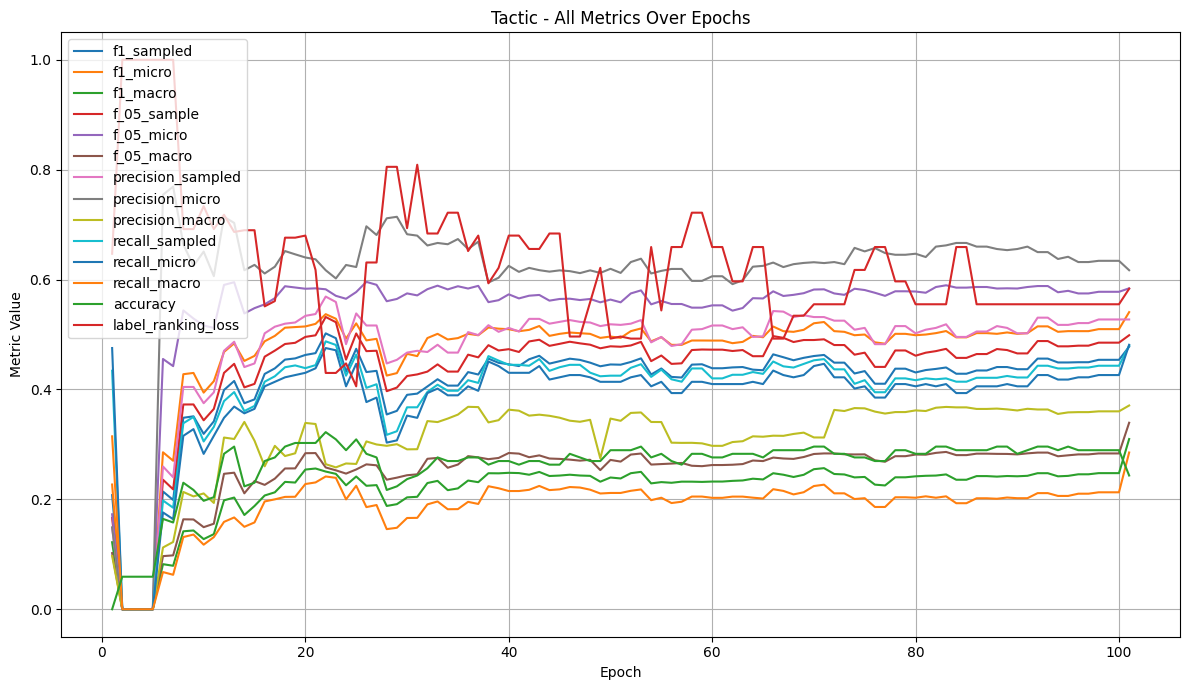

In [44]:
plt.figure(figsize=(12, 7))
epochs = range(1, len(metrics_log) + 1)
for metric_name, values in metrics_data.items():
    if metric_name != 'lrap' and metric_name != 'coverage_error':
        plt.plot(epochs, values, label=metric_name)

plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Tactic - All Metrics Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

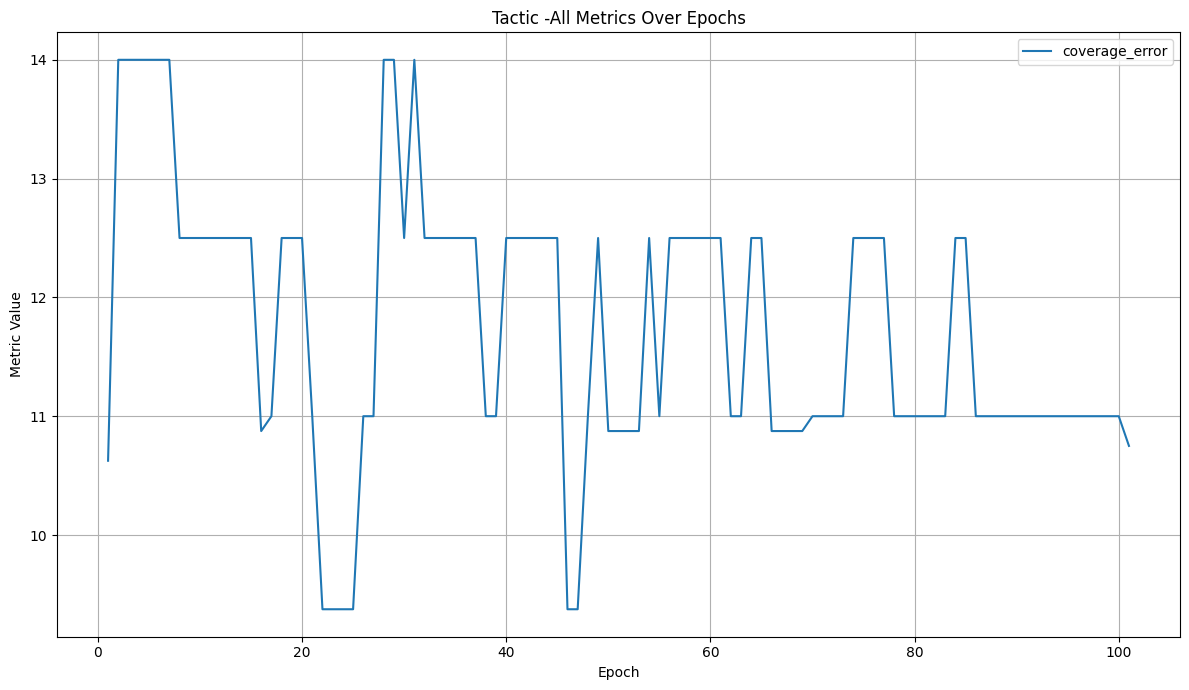

In [45]:
plt.figure(figsize=(12, 7))
epochs = range(1, len(metrics_log) + 1)
for metric_name, values in metrics_data.items():
    # print(f"{metric_name}: {len(values)}")
    if metric_name == 'coverage_error':
        plt.plot(epochs, values, label=metric_name)

plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Tactic -All Metrics Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

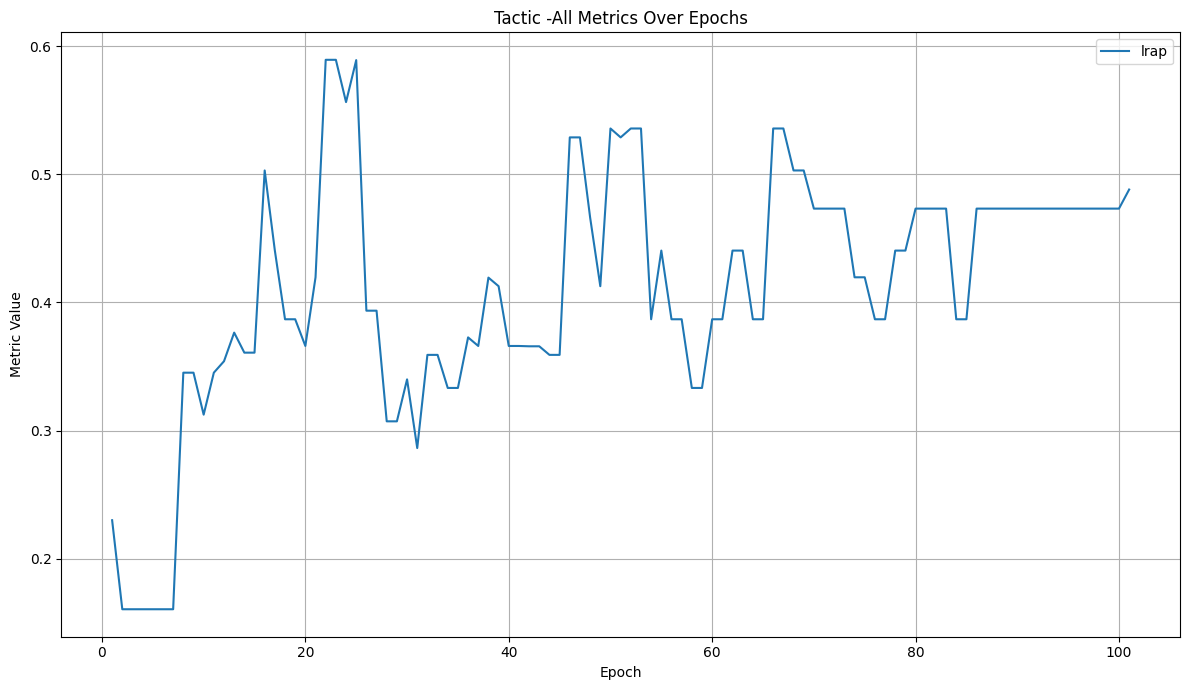

In [46]:
plt.figure(figsize=(12, 7))
epochs = range(1, len(metrics_log) + 1)
for metric_name, values in metrics_data.items():
    # print(f"{metric_name}: {len(values)}")
    if metric_name == 'lrap':
        plt.plot(epochs, values, label=metric_name)

plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Tactic -All Metrics Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [47]:
def print_F1_based_on_distribution(y_true, y_pred, Y, columns):
  fig,ax = plt.subplots()

  results = pd.DataFrame(columns = columns)
  results.loc[len(results)] = f1_score(y_true, y_pred, average=None)


  Y_count = Y.apply(np.sum, axis=0)

  # print(Y_count[0:14])

  Y_count_sorted = Y_count[0:14].sort_values(ascending=False)

  ax.bar(Y_count_sorted.index, Y_count_sorted.values)
  ax.set_xlabel("Tactics")
  ax.set_ylabel("Number of CVEs")
  plt.xticks(rotation=90)

  ax2=ax.twinx()
  ax2.plot(Y_count_sorted.index, results[Y_count_sorted.index].iloc[0], color='red')
  ax2.set_ylabel("F1 Score")

  ax = plt.gca()
  plt.show()

In [65]:
def print_precision_based_on_distribution(y_true, y_pred, Y, columns):
  fig,ax = plt.subplots()

  results = pd.DataFrame(columns = columns)
  results.loc[len(results)] = precision_score(y_true, y_pred, average=None)


  Y_count = Y.apply(np.sum, axis=0)

  # print(Y_count[0:14])

  Y_count_sorted = Y_count[0:14].sort_values(ascending=False)
  # print(Y_count_sorted)

  ax.bar(Y_count_sorted.index, Y_count_sorted.values)
  ax.set_xlabel("Tactics")
  ax.set_ylabel("Number of CVEs")
  plt.xticks(rotation=90)

  ax2=ax.twinx()
  ax2.plot(Y_count_sorted.index, results[Y_count_sorted.index].iloc[0], color='red')
  ax2.set_ylabel("Precision Score")

  ax = plt.gca()
  plt.show()

In [49]:
def compute_metrics(predicted_y, true_y, metric_function, columns, limit):
  results = pd.DataFrame(columns = columns)
  if (metric_function == accuracy_score):
    results.loc[len(results)] = metric_function(true_y, predicted_y)
  else:
    results.loc[len(results)] = metric_function(true_y, predicted_y, average=None)

  sorted_results = results.sort_values(by=0, axis=1, ascending=False)

  for col in sorted_results.columns[:limit]:
        print(f"{col}: {sorted_results[col].values[0]}")

  return sorted_results.iloc[:, :limit]

In [50]:
df = pd.read_csv('merged_all_columns.csv', encoding='utf-8')
# df_attack['tactic_label'] = df_attack.apply(lambda x: list(x[TACTIC]), axis=1)
# df_attack['technique_label'] = df_attack.apply(lambda x: list(x[TECHNIQUE]), axis=1)

df_tactic_labels = df[TACTIC]
df_technique_labels = df[TECHNIQUE]

df['tactic_label'] = df.apply(lambda x: list(x[TACTIC]), axis=1)
df['technique_label'] = df.apply(lambda x: list(x[TECHNIQUE]), axis=1)

df['text_clean'] = df['Text'].map(lambda t: preprocess(t))


train, test = train_test_split(df, test_size=0.2, random_state=2222)
validation, test = train_test_split(test, test_size=0.5, random_state=2222)


In [51]:
print("------Validation results --------")
print(BEST_F1)

print("F1 scores per class")
y_train_df = train.drop(train.columns[0:2], axis=1)

f1_best_metrics = compute_metrics(BEST_PREDICTED, BEST_TRUE, f1_score, test.columns[2:16], 14)
print("----------------------------------")

print("Recall scores per class")
recall_best_metrics = compute_metrics(BEST_PREDICTED, BEST_TRUE, recall_score, test.columns[2:16], 14)
print("----------------------------------")

print("Precision scores per class")
precision_best_metrics = compute_metrics(BEST_PREDICTED, BEST_TRUE, precision_score, test.columns[2:16], 14)
print("----------------------------------")

print("Accuracy scores per class")
acc_best_metrics = compute_metrics(BEST_PREDICTED, BEST_TRUE, accuracy_score, test.columns[2:16], 14)

------Validation results --------
0.5016739334957018
F1 scores per class
TA0040: 0.711864406779661
TA0002: 0.6391752577319587
TA0006: 0.5806451612903226
TA0004: 0.5333333333333333
TA0001: 0.525
TA0009: 0.5
TA0005: 0.10526315789473684
TA0003: 0.0
TA0008: 0.0
TA0007: 0.0
TA0010: 0.0
TA0011: 0.0
TA0042: 0.0
TA0043: 0.0
----------------------------------
Recall scores per class
TA0040: 0.65625
TA0002: 0.5849056603773585
TA0009: 0.5
TA0006: 0.5
TA0001: 0.45652173913043476
TA0004: 0.41379310344827586
TA0005: 0.0625
TA0003: 0.0
TA0008: 0.0
TA0007: 0.0
TA0010: 0.0
TA0011: 0.0
TA0042: 0.0
TA0043: 0.0
----------------------------------
Precision scores per class
TA0040: 0.7777777777777778
TA0004: 0.75
TA0002: 0.7045454545454546
TA0006: 0.6923076923076923
TA0001: 0.6176470588235294
TA0009: 0.5
TA0005: 0.3333333333333333
TA0003: 0.0
TA0008: 0.0
TA0007: 0.0
TA0010: 0.0
TA0011: 0.0
TA0042: 0.0
TA0043: 0.0
----------------------------------
Accuracy scores per class
TA0001: 0.29605263157894735
TA0002

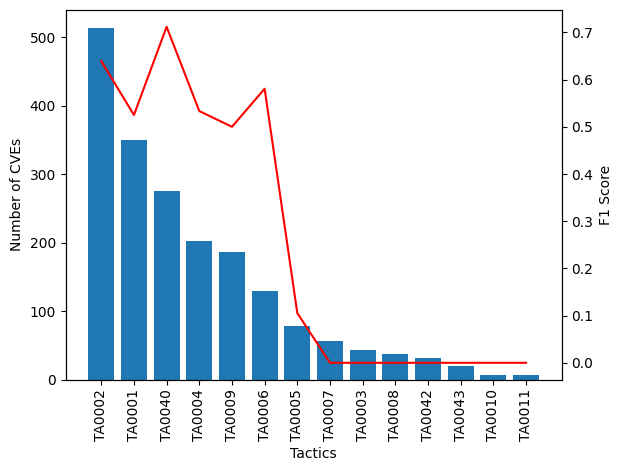

In [52]:
print_F1_based_on_distribution(BEST_PREDICTED, BEST_TRUE, y_train_df,  test.columns[2:16])

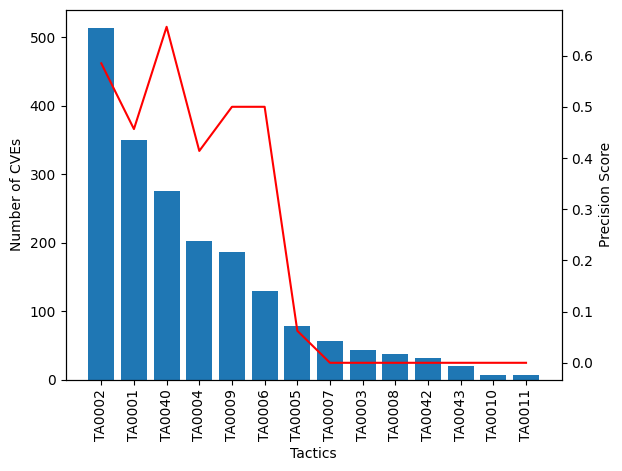

In [66]:
print_precision_based_on_distribution(BEST_PREDICTED, BEST_TRUE, y_train_df,  test.columns[2:16])

In [ ]:
y_train_df = train.drop(train.columns[0:2], axis=1)
Y_count = y_train_df.apply(np.sum, axis=0)
Y_count_sorted = Y_count[0:14].sort_values(ascending=False)

print(Y_count_sorted)

TA0002    514
TA0001    350
TA0040    276
TA0004    202
TA0009    187
TA0006    129
TA0005     78
TA0007     57
TA0003     43
TA0008     38
TA0042     32
TA0043     20
TA0010      7
TA0011      6
dtype: object


In [70]:
y_validation_df = validation.drop(validation.columns[0:2], axis=1)
Y_count_val = y_validation_df.apply(np.sum, axis=0)
Y_count_val_sorted = Y_count_val[0:14].sort_values(ascending=False)
print(Y_count_val_sorted)

TA0002    53
TA0001    46
TA0040    32
TA0004    29
TA0009    28
TA0006    18
TA0005    16
TA0003     8
TA0043     4
TA0007     3
TA0008     3
TA0010     3
TA0042     1
TA0011     0
dtype: object


In [72]:
y_test_df = test.drop(test.columns[0:2], axis=1)
Y_count_test = y_test_df.apply(np.sum, axis=0)
Y_count_test_sorted = Y_count_test[0:14].sort_values(ascending=False)
print(Y_count_test_sorted)

TA0002    70
TA0001    47
TA0040    31
TA0009    22
TA0004    20
TA0006    17
TA0003     8
TA0005     8
TA0008     7
TA0007     5
TA0042     4
TA0043     2
TA0010     0
TA0011     0
dtype: object
